## Eisenhower Tunnel
The following script examines traffic data at the Eisenhower tunnel on I70 East of Denver is Colorado, USA. 


If you are unfamiliar with the tunnel see the Wiki article here
https://en.wikipedia.org/wiki/Eisenhower_Tunnel


We will load the data for across multiple months and years but this is an example of how the monthly data are presented on the CDOT webpage.

#### Example Data fora  single month
https://dtdapps.coloradodot.info/otis/TrafficData/GetDailyTrafficVolumeForStationByMonth/000106/true/2022/3

### Load Primary Packages

In [351]:
#Load pertinent packages

#https://dtdapps.coloradodot.info/otis/TrafficData/GetDailyTrafficVolumeForStationByMonth/000106/true/2022/3

import os
import sys
import time
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
from collections import defaultdict


import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
# Import seaborn
import seaborn as sns


### Data Scraping

We will be working with hourly count data collected by CDOT (Colorado Dept of Transport) at numerous stations across Colorado.  We will be examining the station at the Eisehower tunnel. Data are stored with one column per hour and one row per day for each month. As written the script will pull just over 3 years of data.

In [352]:
# specify stations and dates of interest

# url to format: station ID, year, month
url =  "https://dtdapps.coloradodot.info/otis/TrafficData/GetDailyTrafficVolumeForStationByMonth/{}/true/{}/{}"


#station '000106' is on the eisenhower tunnel I70
stations = ['000106']


# period of interest
years=[ '2015', '2016','2017', '2018','2019','2020','2021']
#years=['2016','2017', '2018','2019']
months= range(1, 13)



### Define web scraping function
define function to pull hourly data for months and years of interest for the Eisenhower station ('000106').

In [353]:
#define function to pull hourly data for months and years of interest
def get_data(url, station_entry, year_entry, month_entry):
     data =[]                    
   
     for station in station_entry:
        for year in year_entry:
            for month in month_entry:
                r2=requests.get(url.format(station,year,month))
                df_list2 = pd.read_html(r2.text, skiprows=0)
                df2=df_list2[0]  #confirmed type is pd.df
                data.append(df2)                             
                
        return data 
        
station=get_data(url,stations,years,months)  



#pd.DataFrame(final)
# Examine first few rows of the data frame.
traffic_pd=pd.concat(station, axis=0)
traffic_pd.head()

# this may take 30 seconds to a  minute.

Count Date Dir   0h   1h  2h   3h   4h   5h   6h    7h    8h    9h   10h  \
0  01/01/2015   P   81   70  41   55   77  129  252   380   574   907  1248   
1  01/01/2015   S   97   91  68   90   71   88  317  1278  1791  1452  1428   
2  01/02/2015   P   96   61  66   89  156  327  623   890  1091  1529  2007   
3  01/02/2015   S  125  103  61   78   99  183  382  1404  1712  1508  1645   
4  01/03/2015   P  100   92  83  101  180  341  706   836  1367  1436  2128   

    11h   12h   13h   14h   15h   16h   17h   18h   19h   20h   21h  22h  23h  
0  1527  1672  1761  1882  2037  1613  1581  1207   786   580   356  194  142  
1  1512  1451  1439  1386  1389  1111   806   630   460   392   279  205  170  
2  2124  1884  2014  2322  2423  1260  1936  1687  1844   791   486  293  190  
3  1760  1791  1885  1908  1640  1428  1188   984   929   688   503  358  254  
4  2118  1832  1273  1221  1147  1296  1340  1356  1260  1267  1406  356  167

In [354]:
# transform wide data to long

traffic_long = traffic_pd.melt(
    id_vars=['Count Date', 'Dir'],
    var_name='hour', value_name='vehicles_per_hour')


traffic_long['hour']=traffic_long['hour'].replace("h", "",regex=True)
traffic_long['hour']=traffic_long['hour'].astype('int')

#change vehicles to integer
traffic_long['vehicles_per_hour']=traffic_long['vehicles_per_hour'].astype('int')

# Specify input format
traffic_long["Count Date"] =  pd.to_datetime(traffic_long["Count Date"], format="%m/%d/%Y")
#traffic_long["Dir"] =  traffic_long['Dir'].astype("S")

#rename columns
traffic_long=traffic_long.rename(columns={"Count Date": "count_date", "Dir": "direction"})

#sort by date, hour
traffic_long = traffic_long.sort_values(by = ['count_date' ,'hour'])
traffic_long=traffic_long.reindex( )

#print main features
traffic_long.dtypes

#Data dimensions
print( "The extracted data have the following dimensions" +  str(traffic_long.shape))

#print first few rows
traffic_long.head()

The extracted data have the following dimensions(114336, 4)


count_date direction  hour  vehicles_per_hour
0    2015-01-01         P     0                 81
1    2015-01-01         S     0                 97
4764 2015-01-01         P     1                 70
4765 2015-01-01         S     1                 91
9528 2015-01-01         P     2                 41

### Quality check
Examine data for missing values and 5 point summaries

In [355]:


# count missing values in each column
print(traffic_long.isnull().sum())

#Check total counts
traffic_long.count()


count_date           0
direction            0
hour                 0
vehicles_per_hour    0
dtype: int64


count_date           114336
direction            114336
hour                 114336
vehicles_per_hour    114336
dtype: int64

In [356]:
#Check range of values
def min_max(df,col):
    max_value=df[col].max()
    min_value=df[col].min()
    print(min_value,max_value)
    
    
min_max(traffic_long, 'count_date')    
#
min_max(traffic_long, 'vehicles_per_hour')



2015-01-01 00:00:00 2021-12-31 00:00:00
0 5625


### Summary
Examine data for missing values and 5 point summaries

In [357]:
# calculate a 5-number summary of traffic data
from numpy import percentile
from numpy.random import rand
# generate data sample
# calculate quartiles
quartiles = percentile(traffic_long['vehicles_per_hour'], [25, 50, 75])
# calculate min/max
data_min, data_max = traffic_long['vehicles_per_hour'].min(), traffic_long['vehicles_per_hour'].max()
# print 5-number summary
print('Min: %.3f' % data_min)
print('Q1: %.3f' % quartiles[0])
print('Median: %.3f' % quartiles[1])
print('Q3: %.3f' % quartiles[2])
print('Max: %.3f' % data_max)

Min: 0.000
Q1: 179.000
Median: 602.000
Q3: 1100.000
Max: 5625.000


In [358]:
hourly_traffic=traffic_long


Data are in good shape. 2017 appears to have some missing dates


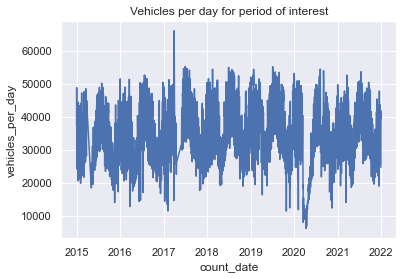

In [359]:
# Calculate daily sums regardless of direction to QC plot
daily_traffic = traffic_long.groupby('count_date').sum()
daily_traffic=daily_traffic.rename(columns={"vehicles_per_hour": "vehicles_per_day"})

# Plot all time
sns.lineplot(data=daily_traffic, x="count_date", y="vehicles_per_day").set(
    title="Vehicles per day for period of interest")
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(25,10)})
#Plot standardized to day of year


print("Data are in good shape. 2017 appears to have some missing dates")



### Identify missing rows
Missing dates are missing entirely with no row for the missing day and hour.  The following section will create one row for hour between the start and end of our period of interest. 

In [360]:
#View the existing data frame
hourly_traffic.head()

count_date direction  hour  vehicles_per_hour
0    2015-01-01         P     0                 81
1    2015-01-01         S     0                 97
4764 2015-01-01         P     1                 70
4765 2015-01-01         S     1                 91
9528 2015-01-01         P     2                 41

In [361]:
# create hourly data frame, duplicate for direction, join with true data
start=hourly_traffic['count_date'].min()
end=hourly_traffic['count_date'].max()

hourly_rows = pd.DataFrame(
        {'count_datetime': pd.date_range(start, end, freq='1H', closed='left')}
     )
hourly_rows['temp']=1
print(len(hourly_rows)*2)
hourly_rows.head()

122688


count_datetime  temp
0 2015-01-01 00:00:00     1
1 2015-01-01 01:00:00     1
2 2015-01-01 02:00:00     1
3 2015-01-01 03:00:00     1
4 2015-01-01 04:00:00     1

In [362]:
direction = [['P'], ['S']]
 
# Create the pandas DataFrame
direction = pd.DataFrame(direction, columns = ['direction'])
direction['temp']=1
direction.head()

direction  temp
0         P     1
1         S     1

In [363]:
hourly_rows_empty =pd.merge(
                   hourly_rows,
                   direction,
                   how="left",
                   on='temp')

hourly_rows_empty=hourly_rows_empty.drop('temp', axis=1)
print(len(hourly_rows_empty))


#print first few rows
hourly_rows_empty.head(6)

122688


count_datetime direction
0 2015-01-01 00:00:00         P
1 2015-01-01 00:00:00         S
2 2015-01-01 01:00:00         P
3 2015-01-01 01:00:00         S
4 2015-01-01 02:00:00         P
5 2015-01-01 02:00:00         S

In [364]:
#check data type
hourly_rows_empty.dtypes

count_datetime    datetime64[ns]
direction                 object
dtype: object

In [365]:

#add hours to datetime ahead of join
hourly_traffic['count_datetime']= hourly_traffic['count_date'] + pd.to_timedelta(hourly_traffic['hour'], unit='h').copy()

hourly_traffic.head()


count_date direction  hour  vehicles_per_hour      count_datetime
0    2015-01-01         P     0                 81 2015-01-01 00:00:00
1    2015-01-01         S     0                 97 2015-01-01 00:00:00
4764 2015-01-01         P     1                 70 2015-01-01 01:00:00
4765 2015-01-01         S     1                 91 2015-01-01 01:00:00
9528 2015-01-01         P     2                 41 2015-01-01 02:00:00

In [366]:
hourly_traffic_full = pd.merge(hourly_rows_empty, hourly_traffic, how='left', on=['count_datetime', 'direction'])

hourly_traffic_full.head()

count_datetime direction count_date  hour  vehicles_per_hour
0 2015-01-01 00:00:00         P 2015-01-01   0.0               81.0
1 2015-01-01 00:00:00         S 2015-01-01   0.0               97.0
2 2015-01-01 01:00:00         P 2015-01-01   1.0               70.0
3 2015-01-01 01:00:00         S 2015-01-01   1.0               91.0
4 2015-01-01 02:00:00         P 2015-01-01   2.0               41.0

We now have a complete data frame with one row per hour from the start to end of our period of interest. There are ~5500 rows will null traffic counts.

In [367]:

# check for missing values
print(hourly_traffic_full.isnull().sum())

count_datetime          0
direction               0
count_date           8400
hour                 8400
vehicles_per_hour    8400
dtype: int64


<AxesSubplot:>

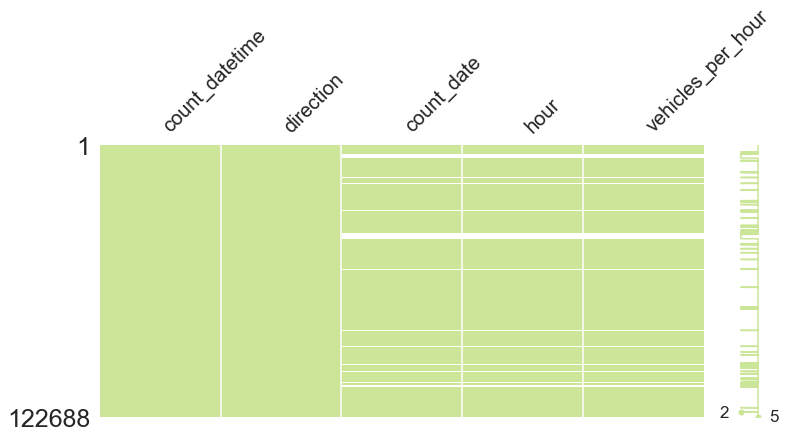

In [368]:
import missingno as msno
%matplotlib inline
msno.matrix(hourly_traffic_full.sort_values('count_datetime'), fontsize=20, figsize=(12,5), color=(0.8, 0.9, .6))

# Values are sorted by time, missing values occur at certain times due to outages

In [369]:
# Recalculate count date column to fill in missing values
hourly_traffic_full['count_date'] =  pd.to_datetime(pd.to_datetime(hourly_traffic_full['count_datetime']).dt.date)

#get hour from count_date time
hourly_traffic_full['hour'] = hourly_traffic_full['count_datetime'].dt.hour

# flag missing rows. We will track imputed rows
# True are measured, false will be imputed using the mean for a given weak
hourly_traffic_full['measured']=hourly_traffic_full['vehicles_per_hour'].notna()



#add month,week,day for imputing
hourly_traffic_full['month']=hourly_traffic_full['count_date'].dt.month
hourly_traffic_full['week']=hourly_traffic_full['count_date'].dt.isocalendar().week
hourly_traffic_full['day']=hourly_traffic_full['count_date'].dt.day_of_week

hourly_traffic_full.head()


count_datetime direction count_date  hour  vehicles_per_hour  measured  \
0 2015-01-01 00:00:00         P 2015-01-01     0               81.0      True   
1 2015-01-01 00:00:00         S 2015-01-01     0               97.0      True   
2 2015-01-01 01:00:00         P 2015-01-01     1               70.0      True   
3 2015-01-01 01:00:00         S 2015-01-01     1               91.0      True   
4 2015-01-01 02:00:00         P 2015-01-01     2               41.0      True   

   month  week  day  
0      1     1    3  
1      1     1    3  
2      1     1    3  
3      1     1    3  
4      1     1    3

In [370]:
hourly_traffic_full['vehicles_per_hour'] = hourly_traffic_full.groupby(['month', 'day','hour', 'direction'])['vehicles_per_hour']\
    .transform(lambda x: x.fillna(x.mean()))

#print null counts
print(hourly_traffic_full.isnull().sum())

count_datetime       0
direction            0
count_date           0
hour                 0
vehicles_per_hour    0
measured             0
month                0
week                 0
day                  0
dtype: int64


In [371]:
# check first few rows
hourly_traffic_full.head()

count_datetime direction count_date  hour  vehicles_per_hour  measured  \
0 2015-01-01 00:00:00         P 2015-01-01     0               81.0      True   
1 2015-01-01 00:00:00         S 2015-01-01     0               97.0      True   
2 2015-01-01 01:00:00         P 2015-01-01     1               70.0      True   
3 2015-01-01 01:00:00         S 2015-01-01     1               91.0      True   
4 2015-01-01 02:00:00         P 2015-01-01     2               41.0      True   

   month  week  day  
0      1     1    3  
1      1     1    3  
2      1     1    3  
3      1     1    3  
4      1     1    3

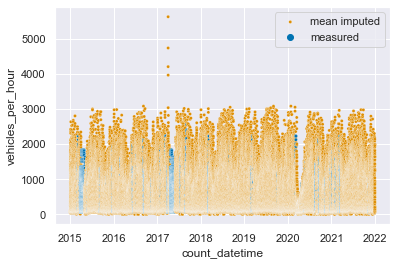

In [372]:
g=sns.scatterplot(data=hourly_traffic_full, x="count_datetime", y="vehicles_per_hour",
                  hue="measured", palette='colorblind' , s=10 )


plt.legend( loc='upper right', labels=['mean imputed', 'measured'])
plt.show()


In [373]:
# Bring in the weather data. fill in missing values

## Weather Data

Traffic counts and delays are closely related to road conditions. Eisenhower Tunnel is at 11,158' ft elevation and 26 ft (~8 m) annual snowfall. Recent snowfall has the potential to adjust the behavior of drivers; drivers may wait for roads to be cleared or may take the opportunity to ski fresh snow.  The next portion will bring in the weather data, check for nulls, confirm data have the proper data types, and join with the traffic data.  We will be working with hourly weather data sampled to the dates in our current data set. 

We will be shifting our focus to preparing weather data before combining the two data sources.

In [374]:
# Import Meteostat library and dependencies
from datetime import datetime
import meteostat 
from meteostat import Point, Hourly
from meteostat import Stations

# data dictionary can be found here:
#https://dev.meteostat.net/python/hourly.html

# set station coordinates and pull data using "fetch"
stations = Stations()
stations = stations.nearby(39.7842, -106.1634)  # Slate Creek/Copper Mountain near Eisenhower Tunnel
station = stations.fetch(1)


# print station
print("Weather Station name")
print(station.iloc[0:4, 0:4].transpose())

print("############")

print("station data types")
print(station.dtypes.head(4))

# set date range from HOURLY TRAFFIC
start = hourly_traffic['count_datetime'].min()
end = hourly_traffic['count_datetime'].max()



hourly_weather = Hourly(station, start=start, end=end)
hourly_weather = hourly_weather.normalize()
hourly_weather = hourly_weather.interpolate()
data_get = hourly_weather.fetch()

#convert to pandas DF
hourly_weather= pd.DataFrame(data=data_get)
hourly_weather.reset_index(inplace=True)

hourly_weather.head()


Weather Station name
id                               KCCU0
name     Copper Mountain / Slate Creek
country                             US
region                              CO
wmo                               <NA>
############
station data types
name       object
country    string
region     string
wmo        string
dtype: object


time  temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  pres  \
0 2015-01-01 00:00:00 -10.0 -15.9  62.0   NaN   NaN  150.0  14.8   NaN   NaN   
1 2015-01-01 01:00:00 -10.0 -15.9  62.0   NaN   NaN  150.0  14.8   NaN   NaN   
2 2015-01-01 02:00:00 -10.0 -15.9  62.0   NaN   NaN  140.0  16.6   NaN   NaN   
3 2015-01-01 03:00:00 -10.0 -16.9  57.0   NaN   NaN  170.0  27.7   NaN   NaN   
4 2015-01-01 04:00:00  -8.0 -17.1  48.0   NaN   NaN  160.0  33.5   NaN   NaN   

   tsun  coco  
0   NaN   NaN  
1   NaN   NaN  
2   NaN   NaN  
3   NaN   NaN  
4   NaN   NaN

In [375]:
print(end)
hourly_weather['time'].max()

2021-12-31 23:00:00


Timestamp('2021-12-31 23:00:00')

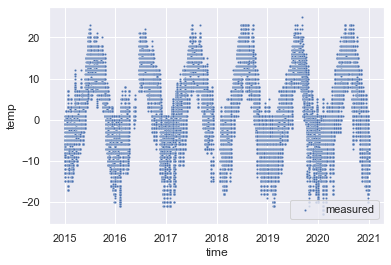

In [376]:
#Plot Temperature vs date 
import plotly.express as px



g=sns.scatterplot(data=hourly_weather, x="time", y="temp", s=5 )


plt.legend( loc='lower right', labels=['measured'])
plt.show()


#note that the data only go through December 2020


## Temperature Data Cleanup

Data were pulled from the Copper Mountain and granby Weather Stations, the two closest weather stations to the Eisenhower Tunnel.  The data are in celsius and metric units.
Temperature data will be checked for missing and data types. As of May 2022 the data were only complete through the end of 2020

### Missing Values

In [377]:

# get data types
hourly_weather.dtypes

# count missing

percent_missing = hourly_weather.isnull().sum() * 100 / len(hourly_weather)
missing_weather_prcnt = pd.DataFrame({'column_name': hourly_weather.columns,
                                 'percent_missing': percent_missing}).sort_values('percent_missing', ascending=False)

#print percent missing 100 = 100% data are missing
missing_weather_prcnt

column_name  percent_missing
snow        snow       100.000000
wpgt        wpgt       100.000000
pres        pres       100.000000
tsun        tsun       100.000000
coco        coco        95.608460
prcp        prcp        92.890431
wdir        wdir        29.370356
wspd        wspd        29.138965
dwpt        dwpt        21.553578
rhum        rhum        21.553578
temp        temp        21.543801
time        time         0.000000

<AxesSubplot:>

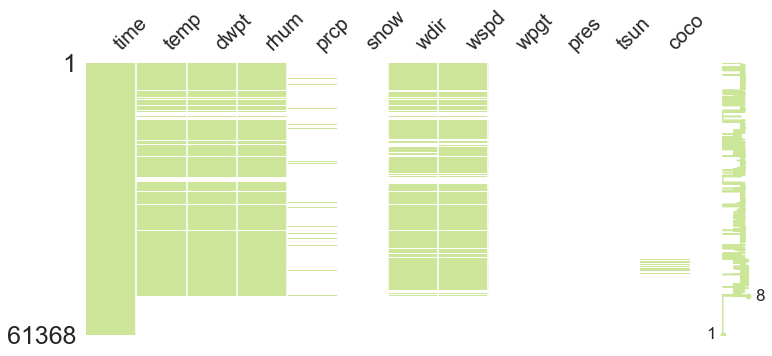

In [378]:
import missingno as msno
%matplotlib inline
msno.matrix(hourly_weather.sort_values('time'), fontsize=20, figsize=(12,5), color=(0.8, 0.9, .6))

# Values are sorted by time, missing values occur at certain times due to outages

#### Missing findings
The hourly weather data have a high degree of missingness.  Temperature (temp), dewpoint (dwpt), and relative humidity (rhum) can be used with confidence. The ppecipitation field can be used, it will be assumed that missing values record 0 precipitation.

Next steps are to subset the columns, clarify names, and check data types.

In [379]:

take_col = ['time', 'temp', 'dwpt', 'rhum', 'prcp']
hourly_weather_sub = pd.DataFrame(hourly_weather, columns=take_col)


#rename columns for clarity
hourly_weather_sub=hourly_weather_sub.rename(columns={"temp": "temp_celsius", "dwpt": "dew_pnt", "rhum": "rel_humidity", "prcp": "prcp_mm"})

#flag missing values to  track imputed rows
# True are measured, false will be imputed later
hourly_weather_sub['temp_celsius_measured']=hourly_weather_sub['temp_celsius'].notna()

hourly_weather_sub['dew_pnt_measured']=hourly_weather_sub['dew_pnt'].notna()

hourly_weather_sub['rel_humidity_measured']=hourly_weather_sub['rel_humidity'].notna()



#add month,week,day for imputing
hourly_weather_sub['month']=hourly_weather_sub['time'].dt.month
hourly_weather_sub['day']=hourly_weather_sub['time'].dt.day
hourly_weather_sub['hour']=hourly_weather_sub['time'].dt.hour

# replace missing precipitation
hourly_weather_sub['prcp_mm'] = hourly_weather_sub['prcp_mm'].fillna(0)


#substitute temperature using mean method.  We will fill other missing values with regression
hourly_weather_sub['temp_celsius'] = hourly_weather_sub.groupby(['month', 'day','hour'])['temp_celsius']\
    .transform(lambda x: x.fillna(x.mean()))

#drop extraneous columns
hourly_weather_sub=hourly_weather_sub.drop(['month', 'day','hour'], axis = 1)


hourly_weather_sub.head()
#hourly_weather_sub.info()



time  temp_celsius  dew_pnt  rel_humidity  prcp_mm  \
0 2015-01-01 00:00:00         -10.0    -15.9          62.0      0.0   
1 2015-01-01 01:00:00         -10.0    -15.9          62.0      0.0   
2 2015-01-01 02:00:00         -10.0    -15.9          62.0      0.0   
3 2015-01-01 03:00:00         -10.0    -16.9          57.0      0.0   
4 2015-01-01 04:00:00          -8.0    -17.1          48.0      0.0   

   temp_celsius_measured  dew_pnt_measured  rel_humidity_measured  
0                   True              True                   True  
1                   True              True                   True  
2                   True              True                   True  
3                   True              True                   True  
4                   True              True                   True

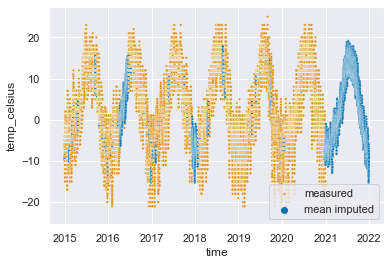

In [380]:
# plot temperature by data source (measured/imputed)


g=sns.scatterplot(data=hourly_weather_sub, x="time", y="temp_celsius",
                  hue="temp_celsius_measured", palette='colorblind' , s=5 )


plt.legend( loc='lower right', labels=['measured', 'mean imputed'])
plt.show()




### Weather Data Replace NA

Now that all rows have a temperature value we will impute an estimate for dew point and relative humidity

In [381]:
#count missing
print(hourly_weather_sub.isnull().sum())

time                         0
temp_celsius                 0
dew_pnt                  13227
rel_humidity             13227
prcp_mm                      0
temp_celsius_measured        0
dew_pnt_measured             0
rel_humidity_measured        0
dtype: int64


In [382]:
# Check to correlation between temperature and the other variables
hourly_weather_sub[["temp_celsius", "dew_pnt", "rel_humidity", "prcp_mm"]].corr()

temp_celsius   dew_pnt  rel_humidity   prcp_mm
temp_celsius      1.000000  0.597602     -0.541546  0.088357
dew_pnt           0.597602  1.000000      0.311457  0.191445
rel_humidity     -0.541546  0.311457      1.000000  0.102171
prcp_mm           0.088357  0.191445      0.102171  1.000000

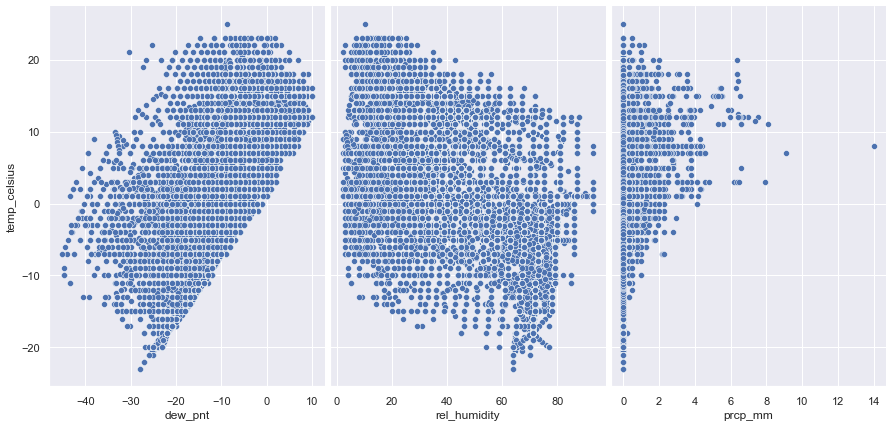

In [383]:
# visualize the relationship between the features and the Temperature (Celsius) using scatterplots
sns.pairplot(hourly_weather_sub, x_vars=['dew_pnt','rel_humidity','prcp_mm'], y_vars='temp_celsius', height=6, aspect=0.7)

## Weather observations

Temperature is positively correlated with dew point and negatively correlated with relative humidity.  Relative humidity is higher in colder weather.  Looking at the Plots this relationship can be observed but there's high variability in the data.  Also, there appears to be a uniform overprint in the relative humidty plot.  This is due to us selecting the normalization and interpolation options when we imported the data.  The source of the weather data already did some interpolation of missing values which is creating the observed trend.  We will fit a linear model to "impute" missing values for relative humidity and dew point.


In [384]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Temperature is the most complete

# create model of dew point given temperature and precipitation
dew_mod = ols("dew_pnt ~ temp_celsius+ prcp_mm+ prcp_mm*temp_celsius", data=hourly_weather_sub).fit()

dew_model_summary = dew_mod.summary()
dew_model_summary



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dew_pnt   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     9658.
Date:                Thu, 23 Jun 2022   Prob (F-statistic):               0.00
Time:                        21:04:11   Log-Likelihood:            -1.5511e+05
No. Observations:               48141   AIC:                         3.102e+05
Df Residuals:                   48137   BIC:                         3.103e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -9.9044      0.029   -337.853      0.000      -9.962      -9.847
temp_celsius             0.5070      0.003    160.402      0.000       0.501       0.513
prcp_mm                  2.9237      0.144     20.372      0.000       2.642       3.205
prcp_mm:temp_celsius     0.0115      0.014      0.801      0.423      -0.017       0.040
==============================================================================
Omnibus:                     9367.503   Durbin-Watson:                   0.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20286.298
Skew:                          -1.135   Prob(JB):                         0.00
Kurtosis:                       5.227   Cond. No.                         48.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

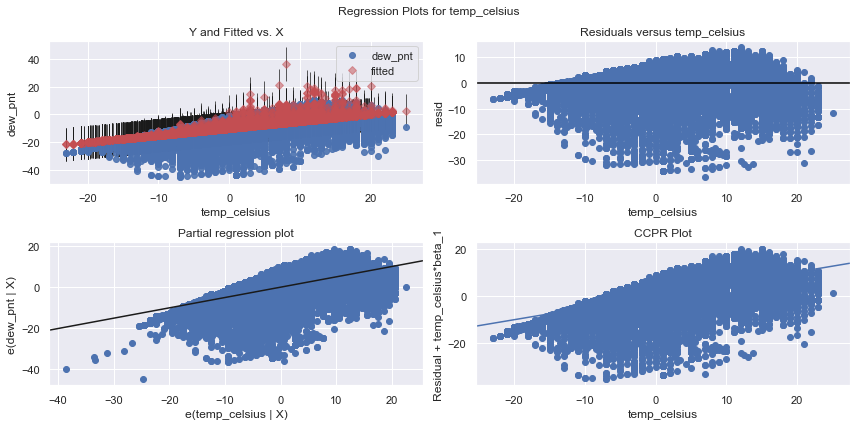

In [385]:
import statsmodels

fig = plt.figure(figsize=(12,6))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(dew_mod, "temp_celsius", fig=fig)

In [386]:
# Create humidity model
# create model of dew point given temperature and precipitation
rel_humid_mod = ols("rel_humidity ~ temp_celsius+ prcp_mm+ prcp_mm*temp_celsius", data=hourly_weather_sub).fit()

rel_humid_summary = rel_humid_mod.summary()
rel_humid_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rel_humidity   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     7440.
Date:                Thu, 23 Jun 2022   Prob (F-statistic):               0.00
Time:                        21:04:14   Log-Likelihood:            -2.0819e+05
No. Observations:               48141   AIC:                         4.164e+05
Df Residuals:                   48137   BIC:                         4.164e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               53.4169      0.088    604.999      0.000      53.244      53.590
temp_celsius            -1.3863      0.010   -145.633      0.000      -1.405      -1.368
prcp_mm                 10.3393      0.432     23.920      0.000       9.492      11.186
prcp_mm:temp_celsius    -0.0685      0.043     -1.583      0.114      -0.153       0.016
==============================================================================
Omnibus:                      769.281   Durbin-Watson:                   0.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              756.414
Skew:                          -0.282   Prob(JB):                    5.58e-165
Kurtosis:                       2.755   Cond. No.                         48.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

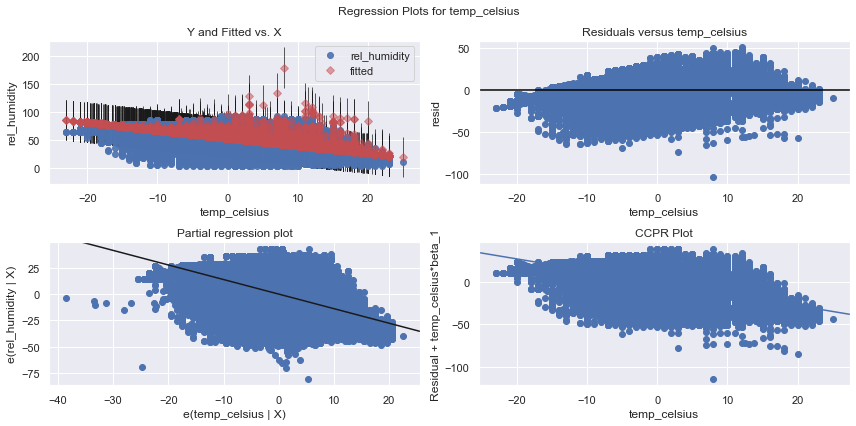

In [387]:
#Evaluate the rel humidity model 
fig = plt.figure(figsize=(12,6))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(rel_humid_mod, "temp_celsius", fig=fig)

In [388]:


# create predictions for dew point and relative humidity

hourly_weather_sub['pred_dwpnt']=dew_mod.predict(hourly_weather_sub)

hourly_weather_sub['pred_rhum']=rel_humid_mod.predict(hourly_weather_sub)


hourly_weather_sub.head()

time  temp_celsius  dew_pnt  rel_humidity  prcp_mm  \
0 2015-01-01 00:00:00         -10.0    -15.9          62.0      0.0   
1 2015-01-01 01:00:00         -10.0    -15.9          62.0      0.0   
2 2015-01-01 02:00:00         -10.0    -15.9          62.0      0.0   
3 2015-01-01 03:00:00         -10.0    -16.9          57.0      0.0   
4 2015-01-01 04:00:00          -8.0    -17.1          48.0      0.0   

   temp_celsius_measured  dew_pnt_measured  rel_humidity_measured  pred_dwpnt  \
0                   True              True                   True  -14.974244   
1                   True              True                   True  -14.974244   
2                   True              True                   True  -14.974244   
3                   True              True                   True  -14.974244   
4                   True              True                   True  -13.960271   

   pred_rhum  
0  67.280294  
1  67.280294  
2  67.280294  
3  67.280294  
4  64.507610

<AxesSubplot:xlabel='pred_dwpnt', ylabel='dew_pnt'>

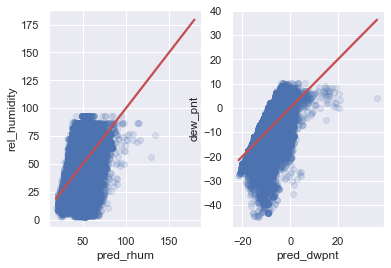

In [389]:
#Create Predicted vs actual plotfor relative humidity (left) and dew point (right)

fig, ax =plt.subplots(1,2)

sns.regplot(x='pred_rhum', y='rel_humidity', data=hourly_weather_sub, line_kws = {"color":"r"}, 
            ci=None,scatter_kws={'alpha':0.15},ax=ax[0])

sns.regplot(x='pred_dwpnt', y='dew_pnt', data=hourly_weather_sub, line_kws = {"color":"r"},
            scatter_kws={'alpha':0.15}, ci=None,ax=ax[1] )



In [390]:


#fill missing rel humidity values with predictions
hourly_weather_sub['dew_pnt'] = hourly_weather_sub['dew_pnt'].fillna(hourly_weather_sub['pred_dwpnt'])

# fill missing dew point values with predictions
hourly_weather_sub['rel_humidity'] = hourly_weather_sub['rel_humidity'].fillna(hourly_weather_sub['pred_rhum'])

#take relevant columns
hourly_weather_final = hourly_weather_sub.drop(['pred_dwpnt', 'pred_rhum','dew_pnt_measured','rel_humidity_measured'], axis = 1)


#print 
hourly_weather_final.head()


time  temp_celsius  dew_pnt  rel_humidity  prcp_mm  \
0 2015-01-01 00:00:00         -10.0    -15.9          62.0      0.0   
1 2015-01-01 01:00:00         -10.0    -15.9          62.0      0.0   
2 2015-01-01 02:00:00         -10.0    -15.9          62.0      0.0   
3 2015-01-01 03:00:00         -10.0    -16.9          57.0      0.0   
4 2015-01-01 04:00:00          -8.0    -17.1          48.0      0.0   

   temp_celsius_measured  
0                   True  
1                   True  
2                   True  
3                   True  
4                   True

In [391]:
#Check for complete data

print("Missing values post imputation")
print(hourly_weather_final.isnull().sum())



Missing values post imputation
time                     0
temp_celsius             0
dew_pnt                  0
rel_humidity             0
prcp_mm                  0
temp_celsius_measured    0
dtype: int64


## Combine Hourly Traffic and weather data

In [392]:
hourly_data_combined =pd.merge(
                   hourly_traffic_full,
                   hourly_weather_final,
                   how="left",
                   left_on=['count_datetime'],
                   right_on=['time']
)
#drop 
hourly_data_combined=hourly_data_combined.drop(['time'], axis = 1)

#rearrange columns
cols = hourly_data_combined.columns.tolist()
cols = ['count_date',
    'count_datetime',
    'direction',
    'month',
    'week',
    'hour',
    'vehicles_per_hour',
    'temp_celsius',
    'dew_pnt',
    'rel_humidity',
    'prcp_mm',
     'measured',
    'temp_celsius_measured']

hourly_data_combined = hourly_data_combined[cols]
# print first few rows
hourly_data_combined.head()



count_date      count_datetime direction  month  week  hour  \
0 2015-01-01 2015-01-01 00:00:00         P      1     1     0   
1 2015-01-01 2015-01-01 00:00:00         S      1     1     0   
2 2015-01-01 2015-01-01 01:00:00         P      1     1     1   
3 2015-01-01 2015-01-01 01:00:00         S      1     1     1   
4 2015-01-01 2015-01-01 02:00:00         P      1     1     2   

   vehicles_per_hour  temp_celsius  dew_pnt  rel_humidity  prcp_mm  measured  \
0               81.0         -10.0    -15.9          62.0      0.0      True   
1               97.0         -10.0    -15.9          62.0      0.0      True   
2               70.0         -10.0    -15.9          62.0      0.0      True   
3               91.0         -10.0    -15.9          62.0      0.0      True   
4               41.0         -10.0    -15.9          62.0      0.0      True   

   temp_celsius_measured  
0                   True  
1                   True  
2                   True  
3                   True  
4                   True

In [393]:
print("Missing values post imputation")
print(hourly_data_combined.isnull().sum())

Missing values post imputation
count_date               0
count_datetime           0
direction                0
month                    0
week                     0
hour                     0
vehicles_per_hour        0
temp_celsius             0
dew_pnt                  0
rel_humidity             0
prcp_mm                  0
measured                 0
temp_celsius_measured    0
dtype: int64


## Add descriptive columns



In [394]:
# calculate the day of the year for time_series plots
hourly_data_combined['day_of_year'] = hourly_data_combined['count_date'].dt.dayofyear

#calculate day of week number (0 = Monday, 6= Sunday)
hourly_data_combined['day_of_week']=hourly_data_combined['count_date'].dt.day_of_week

# designate weekend ()
hourly_data_combined.loc[hourly_data_combined['day_of_week'] >=5, 'weekend'] = 1 
hourly_data_combined.loc[hourly_data_combined['day_of_week'] <5, 'weekend'] = 0 


# mark American holidays. Note that holidays that fall on weekedns are applied in the preceding or proceeding week.
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start=hourly_data_combined['count_date'].min(),
                        end=hourly_data_combined['count_date'].max()).to_pydatetime()

#designate which days are holidays
hourly_data_combined['holiday'] = hourly_data_combined['count_date'].isin(holidays)


#check that tables look good by printing the first few rows.
hourly_data_combined.head()




count_date      count_datetime direction  month  week  hour  \
0 2015-01-01 2015-01-01 00:00:00         P      1     1     0   
1 2015-01-01 2015-01-01 00:00:00         S      1     1     0   
2 2015-01-01 2015-01-01 01:00:00         P      1     1     1   
3 2015-01-01 2015-01-01 01:00:00         S      1     1     1   
4 2015-01-01 2015-01-01 02:00:00         P      1     1     2   

   vehicles_per_hour  temp_celsius  dew_pnt  rel_humidity  prcp_mm  measured  \
0               81.0         -10.0    -15.9          62.0      0.0      True   
1               97.0         -10.0    -15.9          62.0      0.0      True   
2               70.0         -10.0    -15.9          62.0      0.0      True   
3               91.0         -10.0    -15.9          62.0      0.0      True   
4               41.0         -10.0    -15.9          62.0      0.0      True   

   temp_celsius_measured  day_of_year  day_of_week  weekend  holiday  
0                   True            1            3      0.0     True  
1                   True            1            3      0.0     True  
2                   True            1            3      0.0     True  
3                   True            1            3      0.0     True  
4                   True            1            3      0.0     True

In [395]:
#identify a random date, filter to date of interest, pull the whole week
import datetime as dt
from datetime import timedelta
import random

# select a random date, plot vehicle counts for that day.
min_date= hourly_data_combined['count_date'].min()
max_date= hourly_data_combined['count_date'].max()


#set seed
random.seed(12)

#get random date between the min and max for the dataset 
time_between_dates = max_date - min_date
days_between_dates = time_between_dates.days
random_number_of_days = random.randrange(days_between_dates)
random_date = min_date + timedelta(days=random_number_of_days)

#random day in the data
random_date

#get day of week, create lower and upper bound for filter to 1 random week
#Monday is 0, Sunday is 6
random_day_of_week=  random_date.day_of_week
day_to_add= 6-random_day_of_week
day_to_sub= 0+random_day_of_week
#
#day_to_add
#day_to_sub


#create lower and upper bound filter
upper_bound= random_date + timedelta(days=day_to_add)
#upper_bound

lower_bound= random_date - timedelta(days=day_to_sub)
#lower_bound

#set mask for date filter
mask = (hourly_data_combined['count_date'] >= lower_bound) & (hourly_data_combined['count_date'] <= upper_bound)

#filter data to 1 random week
#print("The first table is for one week that contains our random day ")
one_week = hourly_data_combined.loc[mask]
#print(one_week.head())
#print(one_week.shape)

#filter data to 1 random day
print("The second tables is for one random day ")
one_day= hourly_data_combined.loc[hourly_data_combined['count_date'] == random_date]

one_day.head()

The second tables is for one random day 


count_date      count_datetime direction  month  week  hour  \
93264 2020-04-27 2020-04-27 00:00:00         P      4    18     0   
93265 2020-04-27 2020-04-27 00:00:00         S      4    18     0   
93266 2020-04-27 2020-04-27 01:00:00         P      4    18     1   
93267 2020-04-27 2020-04-27 01:00:00         S      4    18     1   
93268 2020-04-27 2020-04-27 02:00:00         P      4    18     2   

       vehicles_per_hour  temp_celsius  dew_pnt  rel_humidity  prcp_mm  \
93264               62.0           1.0      0.0          93.0      0.0   
93265               59.0           1.0      0.0          93.0      0.0   
93266               32.0           1.0     -2.9          75.0      0.0   
93267               39.0           1.0     -2.9          75.0      0.0   
93268               34.0           1.0     -0.9          87.0      0.0   

       measured  temp_celsius_measured  day_of_year  day_of_week  weekend  \
93264      True                   True          118            0      0.0   
93265      True                   True          118            0      0.0   
93266      True                   True          118            0      0.0   
93267      True                   True          118            0      0.0   
93268      True                   True          118            0      0.0   

       holiday  
93264    False  
93265    False  
93266    False  
93267    False  
93268    False

### Create Plots to examine daily and weekly trends

Now that the data are mined and confirmed to be in good order with minimal missingness we want to get  a feel for any cyclicity in the data.  Traffic counts are a product of road usage.  Given the location of the Eisehower tunnel we will geta  good sense of when people are accessing the mountains.  I70 is a busy interstate and through traffic will be a major component of daily use; however, residents of the front range will drive through the tunnel to access mountain recreation.  We should then expect heavy usage during certain seasons, weekends, and holidays.  We will now examine a random day and random week for patterns in the data.  We will include direction to get a feel for when day-trippers may be returning home from the mountains.


This is a  daily plot for a  random day with direction 


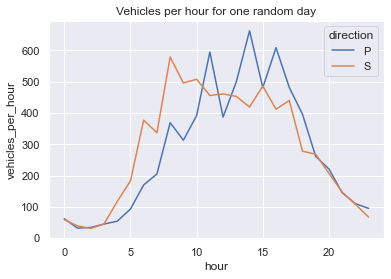

In [396]:
# Daily Plot

print("This is a  daily plot for a  random day with direction ")
sns.lineplot(data=one_day, x="hour", y="vehicles_per_hour", hue="direction").set(
    title="Vehicles per hour for one random day")

sns.set(rc = {'figure.figsize':(10,8)})

In [397]:
# weekly plot random week

#Plot traffic counts vs date 
import plotly.express as px


fig = px.line( x = one_week['count_datetime'] ,
              y = one_week['vehicles_per_hour'],
              color=one_week['direction'],
              title = 'Daily Traffic Counts for a Random  Week')
fig.show()

The patterns observed in this random week from monday to Sunday are typical.  Traffic directions, indicated as "primary" and "secondary" refer to east and westbound traffic respectively.  Resident on the front Range drive west (secondary, "s") to access the mountains.  Each day westward traffic spike around 8 AM and eastbound traffic peaks in the PM.  There is elevated westward traffic on Friday and a large influx Sunday afternoon.
Next we will generate daily totals for all days in the data set.  We will also identify days that fall on weekedns and holidays.



# Data Exploration

## Questions to be considered

1) When is traffic the heaviest?
2) On average what is the busiest day of the week?
3) How does East and West Traffic compare?
4) What is the effect of holidays on traffic counts?
5) What is the effect of precipitation on traffic counts?
6) What are the total traffic counts for each year? What are the trends?
7) Which months and days have the highest traffic counts?
8) What was the impact of the 2020 pandemic on traffic counts?



In [398]:
#ax = sns.heatmap(df, cmap='RdYlGn_r',
#                 robust=True,
#                 fmt='.2f',
#                 annot=True,
#                 linewidths=.5,
#                 annot_kws={'size':11},
#                 cbar_kws={'shrink':.8,
#                           'label':'Precipitation(mm)'})                       
#    
#ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
#plt.title('Average Precipitations', fontdict={'fontsize':18},    pad=14);

In [399]:
# Check out a correlation plot.  If vehicles per hour is our desired response variable, non of the independent vairables have a strong linear relationship

hourly_data_combined[["vehicles_per_hour","day_of_week","day_of_year", "hour","temp_celsius", "dew_pnt", "rel_humidity", "prcp_mm"]].corr()

vehicles_per_hour   day_of_week   day_of_year  \
vehicles_per_hour           1.000000  1.805130e-01 -1.042030e-02   
day_of_week                 0.180513  1.000000e+00 -6.719364e-04   
day_of_year                -0.010420 -6.719364e-04  1.000000e+00   
hour                        0.286175  3.400205e-17 -1.241686e-15   
temp_celsius                0.002834  4.417699e-03  2.170988e-01   
dew_pnt                     0.013546  1.010010e-04  1.058679e-01   
rel_humidity               -0.000892 -7.226138e-03 -1.476731e-01   
prcp_mm                    -0.034702  9.203506e-03  1.344912e-02   

                           hour  temp_celsius   dew_pnt  rel_humidity  \
vehicles_per_hour  2.861751e-01      0.002834  0.013546     -0.000892   
day_of_week        3.400205e-17      0.004418  0.000101     -0.007226   
day_of_year       -1.241686e-15      0.217099  0.105868     -0.147673   
hour               1.000000e+00      0.091706 -0.004934     -0.110114   
temp_celsius       9.170616e-02      1.000000  0.632372     -0.578889   
dew_pnt           -4.934328e-03      0.632372  1.000000      0.229095   
rel_humidity      -1.101140e-01     -0.578889  0.229095      1.000000   
prcp_mm            5.731870e-02      0.088293  0.187682      0.097674   

                    prcp_mm  
vehicles_per_hour -0.034702  
day_of_week        0.009204  
day_of_year        0.013449  
hour               0.057319  
temp_celsius       0.088293  
dew_pnt            0.187682  
rel_humidity       0.097674  
prcp_mm            1.000000

In [400]:
# time and day trends
# get the mean for the data by hour and day

#hourly_data_combined_heat  =  hourly_data_combined[['vehicles_per_hour','month', 'day_of_week', 'hour']]


hourly_data_combined.head()


count_date      count_datetime direction  month  week  hour  \
0 2015-01-01 2015-01-01 00:00:00         P      1     1     0   
1 2015-01-01 2015-01-01 00:00:00         S      1     1     0   
2 2015-01-01 2015-01-01 01:00:00         P      1     1     1   
3 2015-01-01 2015-01-01 01:00:00         S      1     1     1   
4 2015-01-01 2015-01-01 02:00:00         P      1     1     2   

   vehicles_per_hour  temp_celsius  dew_pnt  rel_humidity  prcp_mm  measured  \
0               81.0         -10.0    -15.9          62.0      0.0      True   
1               97.0         -10.0    -15.9          62.0      0.0      True   
2               70.0         -10.0    -15.9          62.0      0.0      True   
3               91.0         -10.0    -15.9          62.0      0.0      True   
4               41.0         -10.0    -15.9          62.0      0.0      True   

   temp_celsius_measured  day_of_year  day_of_week  weekend  holiday  
0                   True            1            3      0.0     True  
1                   True            1            3      0.0     True  
2                   True            1            3      0.0     True  
3                   True            1            3      0.0     True  
4                   True            1            3      0.0     True

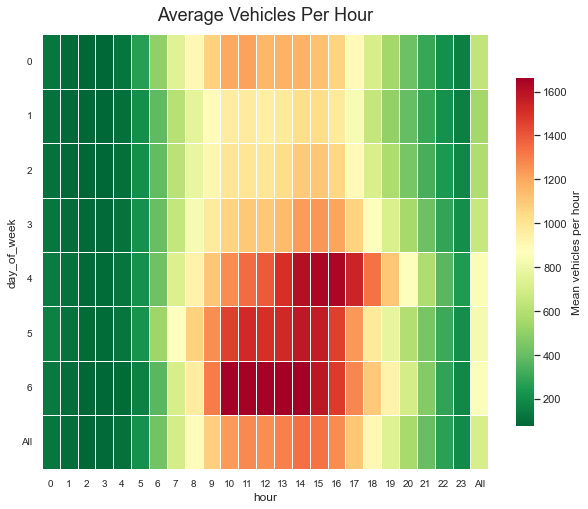

In [401]:
#Get averages by day of week and time
#hourly_data_combined['weekday_text']  =  dayNameFromWeekday(hourly_data_combined['day_of_week'])


all_hours_day_df = pd.pivot_table(data= hourly_data_combined[['vehicles_per_hour', 'day_of_week', 'hour']], 
                                  values="vehicles_per_hour",
                                   index="day_of_week",
                                  columns="hour",
                                  margins=True
                                   )


#print(all_hours_day_df.head(7))


ax = sns.heatmap(all_hours_day_df, cmap='RdYlGn_r',
                 robust=True,
                 fmt='.2f',
                 annot=False,
                 linewidths=.5,
                 annot_kws={'size':8},
                 cbar_kws={'shrink':.8,
                           'label':'Mean vehicles per hour'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Average Vehicles Per Hour', fontdict={'fontsize':18},    pad=14);

#type(hourly_data_combined_heat)

The heat map above has the average traffic counts for Eisenhower tunnel for both the East and West bound lanes combined.  The pattern is clear, the 5-6 (0 index) days of the week, Friday-Sunday have the highest traffic counts.  The average values for Sunday afternoon are > 1600 cars per hour, or 1 car every 2 seconds.  Next we will examine the average effects between each month. 

In [402]:
#divide data into east and westbound
#compare Primary  and Secondary
hourly_data_combined_primary = hourly_data_combined.loc[hourly_data_combined['direction'].isin(['P'])]
all_hours_day_df_primary = pd.pivot_table(data= hourly_data_combined_primary[['vehicles_per_hour', 'day_of_week', 'hour','direction']], 
                                  values="vehicles_per_hour",
                                   index=["day_of_week"],
                                  columns="hour",
                                  margins=True
                                   )
#all_hours_day_df_primary.head()




#compare Primary  and Secondary
hourly_data_combined_secondary = hourly_data_combined.loc[hourly_data_combined['direction'].isin(['S'])]
all_hours_day_df_secondary = pd.pivot_table(data= hourly_data_combined_secondary[['vehicles_per_hour', 'day_of_week', 'hour','direction']], 
                                  values="vehicles_per_hour",
                                   index=["day_of_week"],
                                  columns="hour",
                                  margins=True
                                   )
#all_hours_day_df_secondary.head()
hourly_data_combined_secondary = hourly_data_combined.loc[hourly_data_combined['direction'].isin(['S'])]
all_hours_day_df_secondary = pd.pivot_table(data= hourly_data_combined_secondary[['vehicles_per_hour', 'day_of_week', 'hour','direction']], 
                                  values="vehicles_per_hour",
                                   index=["day_of_week"],
                                  columns="hour",
                                  margins=True
                                   )


hourly_data_combined_secondary.head(3)




count_date      count_datetime direction  month  week  hour  \
1 2015-01-01 2015-01-01 00:00:00         S      1     1     0   
3 2015-01-01 2015-01-01 01:00:00         S      1     1     1   
5 2015-01-01 2015-01-01 02:00:00         S      1     1     2   

   vehicles_per_hour  temp_celsius  dew_pnt  rel_humidity  prcp_mm  measured  \
1               97.0         -10.0    -15.9          62.0      0.0      True   
3               91.0         -10.0    -15.9          62.0      0.0      True   
5               68.0         -10.0    -15.9          62.0      0.0      True   

   temp_celsius_measured  day_of_year  day_of_week  weekend  holiday  
1                   True            1            3      0.0     True  
3                   True            1            3      0.0     True  
5                   True            1            3      0.0     True

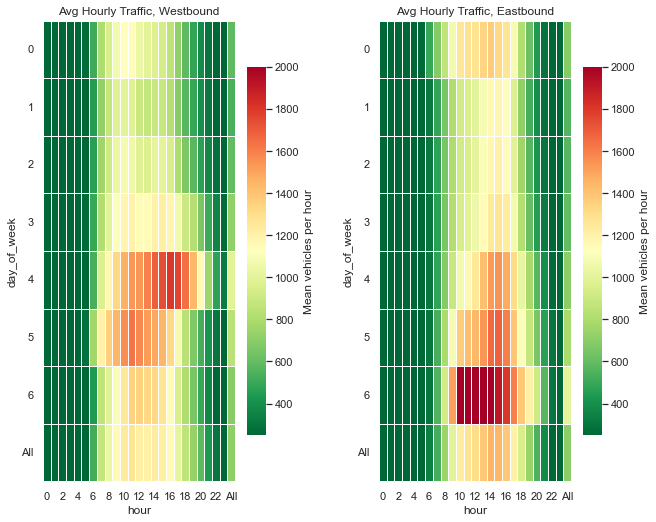

In [403]:

#
#Color maps comparing east and westbound traffic

import numpy as np; np.random.seed(0)
import seaborn as sns

#all_hours_day_df_secondary   
#all_hours_day_df_primary 

fig, ax =plt.subplots(1,2)

sns.heatmap(all_hours_day_df_secondary, ax=ax[0],cmap='RdYlGn_r',
                 robust=True,
                 vmin=250,
                 vmax=2000,
                 fmt='.2f',
                 annot=False,
                 linewidths=.5,
                 annot_kws={'size':8},
                 cbar_kws={'shrink':.8,
                           'label':'Mean vehicles per hour'})
sns.heatmap(all_hours_day_df_primary, ax=ax[1],cmap='RdYlGn_r',
             vmin=250,
                 vmax=2000,
                 robust=True,
                 fmt='.2f',
                 annot=False,
                 linewidths=.5,
                 annot_kws={'size':8},
                 cbar_kws={'shrink':.8,
                           'label':'Mean vehicles per hour'}           
           )
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
ax[0].title.set_text('Avg Hourly Traffic, Westbound')
ax[1].title.set_text('Avg Hourly Traffic, Eastbound')
ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=0, fontsize=11)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0, fontsize=11)
ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=0, fontsize=11)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0, fontsize=11)
sns.set(rc = {'figure.figsize':(21,8)})
plt.show()

Two heatmaps showing the average traffic count for each hour on each day of the week.  Traffic counts are highest 7:00-6:00 on each day of the week.  Westbound traffic is heavier earlier in the day than eastbound traffic.  The heaviest westbound traffic n Friday Afternoon and Saturday, the highest eastbound traffic is on Sunday as commuters return to Denver.

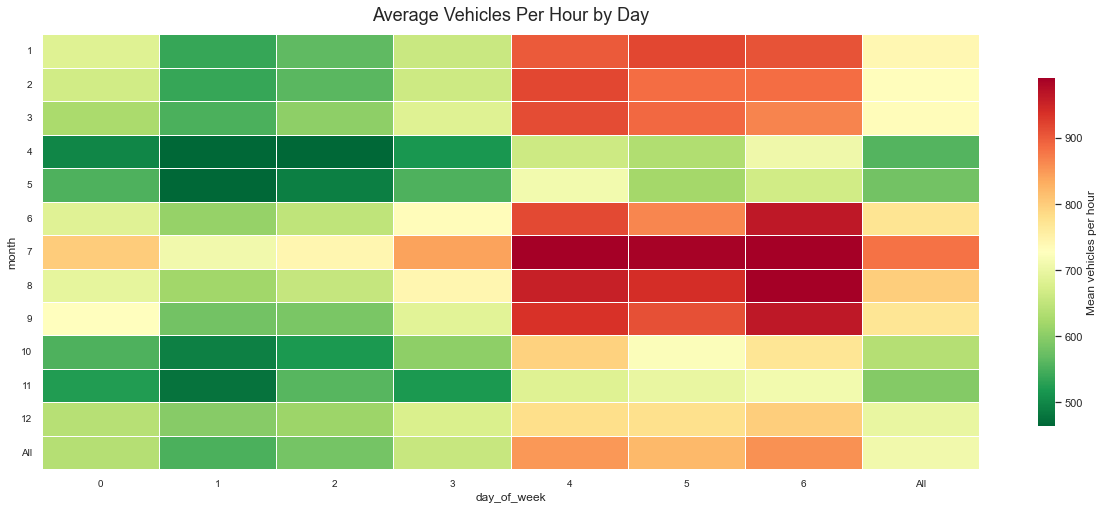

In [404]:
#Get averages by day of week and time

all_months_weeks = pd.pivot_table(data= hourly_data_combined[['vehicles_per_hour', 'month', 'day_of_week']], 
                                  values="vehicles_per_hour",
                                   index="month",
                                  columns="day_of_week",
                                  margins=True
                                   )
#print(all_hours_day_df.head(7))


ax = sns.heatmap(all_months_weeks, cmap='RdYlGn_r',
                
                 robust=True,
                 fmt='.2f',
                 annot=False,
                 linewidths=.5,
                 annot_kws={'size':8},
                 cbar_kws={'shrink':.8,
                           'label':'Mean vehicles per hour'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Average Vehicles Per Hour by Day', fontdict={'fontsize':18},    pad=14);


#type(hourly_data_combined_heat)

The heat map shows the average hourly traffic counts by month for each day of the week.  The averages are much lower than those above because the daily values include all of the low traffic hours in the early morning.  Friday through Sunday are high traffic days in nearly every month.  Traffic is elevated during the ski season, January-March, and during the Summer.  Interestingly the week of fourth of July sees elevated traffic on weekdays.  This is likely due to when the July 4th holiday falls in a given year.  Overall Winter and Summer have the most traffic with reduced traffic in the Fall and Spring.  Traffic is higher in the fall than in the spring.  On average the best day and month to travel is a Tuesday in April or May. One would expect very high traffic on a Saturday afternoon in July.

### Daily totals


In [405]:
hourly_data_combined.head(2)



count_date count_datetime direction  month  week  hour  vehicles_per_hour  \
0 2015-01-01     2015-01-01         P      1     1     0               81.0   
1 2015-01-01     2015-01-01         S      1     1     0               97.0   

   temp_celsius  dew_pnt  rel_humidity  prcp_mm  measured  \
0         -10.0    -15.9          62.0      0.0      True   
1         -10.0    -15.9          62.0      0.0      True   

   temp_celsius_measured  day_of_year  day_of_week  weekend  holiday  
0                   True            1            3      0.0     True  
1                   True            1            3      0.0     True

In [406]:
#compile data to the day.  

fixed_values= hourly_data_combined[["count_date", "month", "week",  "measured",'direction', "temp_celsius_measured", "day_of_week", "weekend", "holiday"]]
fixed_values=fixed_values.drop_duplicates(subset=['count_date', 'direction'], keep='last')


#values to sum
day_values_sum = hourly_data_combined[["count_date", "vehicles_per_hour", "direction","prcp_mm"  ]]
daily_traffic  =  day_values_sum.groupby(['count_date', 'direction']).sum()
daily_traffic=daily_traffic.rename(columns={"vehicles_per_hour": "vehicles_per_day"})



# columns to mean
day_values_mean = hourly_data_combined[["count_date",  "temp_celsius",  "dew_pnt" , "rel_humidity"]]
day_values_mean=day_values_mean.groupby('count_date').mean()

#join sums and fixed header data
daily_data_combined= pd.merge(
    daily_traffic,
    fixed_values,
    how='left',
    on= ['count_date','direction']

)
#
# add pertinent headers
daily_data_combined['day_of_year'] = daily_data_combined['count_date'].dt.dayofyear
daily_data_combined['year'] = daily_data_combined['count_date'].dt.year


daily_data_combined= pd.merge(
    daily_data_combined,
    day_values_mean,
    how='left',
    on= ['count_date']

)


#join with mean data

print(daily_data_combined.shape)
daily_data_combined.head()


(5112, 16)


count_date direction  vehicles_per_day  prcp_mm  month  week  measured  \
0 2015-01-01         P           19152.0      0.0      1     1      True   
1 2015-01-01         S           18001.0      0.0      1     1      True   
2 2015-01-02         P           26189.0      0.0      1     1      True   
3 2015-01-02         S           22616.0      0.0      1     1      True   
4 2015-01-03         P           23409.0      0.0      1     1      True   

   temp_celsius_measured  day_of_week  weekend  holiday  day_of_year  year  \
0                   True            3      0.0     True            1  2015   
1                   True            3      0.0     True            1  2015   
2                   True            4      0.0    False            2  2015   
3                   True            4      0.0    False            2  2015   
4                   True            5      1.0    False            3  2015   

   temp_celsius    dew_pnt  rel_humidity  
0     -7.375000 -15.783333     52.916667  
1     -7.375000 -15.783333     52.916667  
2     -7.698958 -13.336935     64.673873  
3     -7.698958 -13.336935     64.673873  
4     -9.083333 -13.204167     72.625000

In [407]:
daily_data_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5112 entries, 0 to 5111
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   count_date             5112 non-null   datetime64[ns]
 1   direction              5112 non-null   object        
 2   vehicles_per_day       5112 non-null   float64       
 3   prcp_mm                5112 non-null   float64       
 4   month                  5112 non-null   int64         
 5   week                   5112 non-null   UInt32        
 6   measured               5112 non-null   bool          
 7   temp_celsius_measured  5112 non-null   bool          
 8   day_of_week            5112 non-null   int64         
 9   weekend                5112 non-null   float64       
 10  holiday                5112 non-null   bool          
 11  day_of_year            5112 non-null   int64         
 12  year                   5112 non-null   int64         
 13  tem

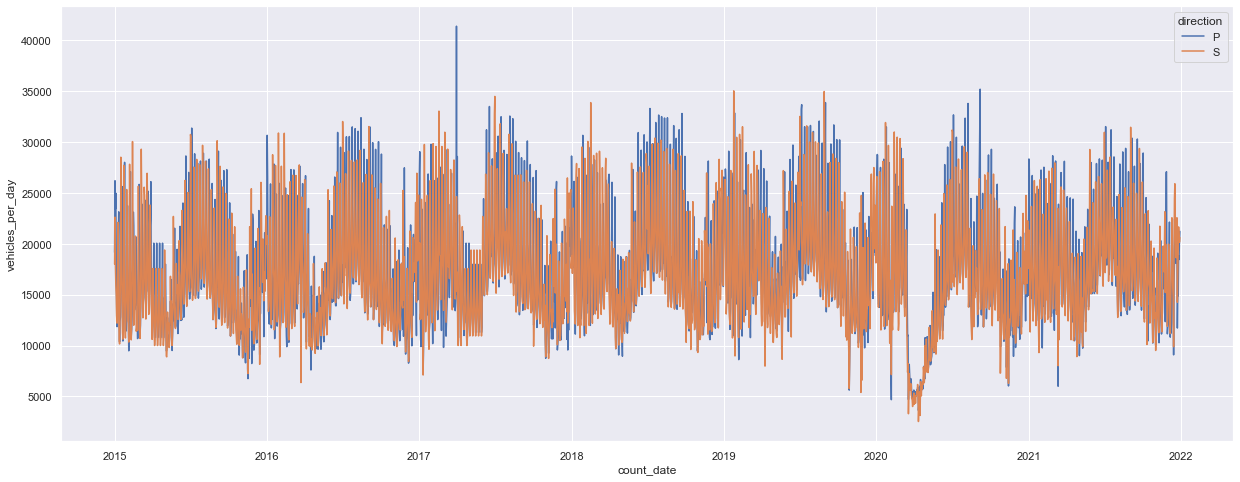

In [408]:
# Plot time series of all data

#Plot Temperature vs date 
import plotly.express as px
#
#
#fig = px.line( x = daily_data_combined['count_date'] ,
#              y = daily_data_combined['vehicles_per_day'],
#              color=daily_data_combined['direction'],
#              title = 'Daily Traffic Counts for years of interest')
#fig.show()

sns.lineplot(data=daily_data_combined, x="count_date", y="vehicles_per_day", hue="direction")
sns.set(rc = {'figure.figsize':(16,5)})

<AxesSubplot:xlabel='day_of_year', ylabel='vehicles_per_day'>

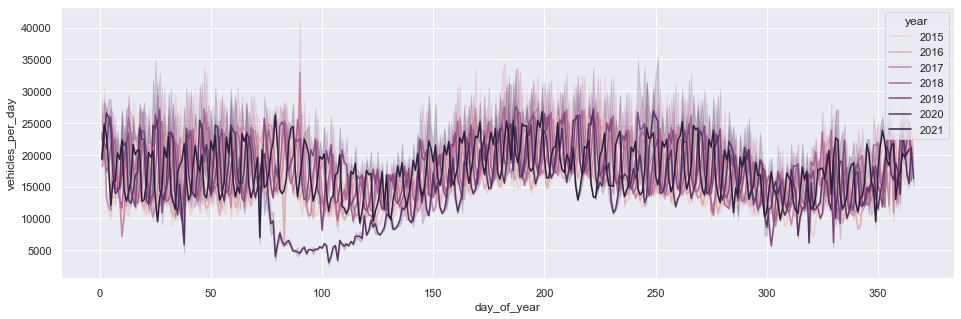

In [409]:
# get value counts for each year.
#Plot standardized to day of year Broken out by year
sns.lineplot(data=daily_data_combined, x="day_of_year", y="vehicles_per_day", hue="year")


In [410]:
# totals regardless of direction

daily_totals= daily_data_combined[["day_of_year","vehicles_per_day","year"]]
daily_totals = daily_totals.groupby(["year", "day_of_year"]).sum()
daily_totals.head()


vehicles_per_day
year day_of_year                  
2015 1                     37153.0
     2                     48805.0
     3                     41113.0
     4                     40841.0
     5                     31751.0

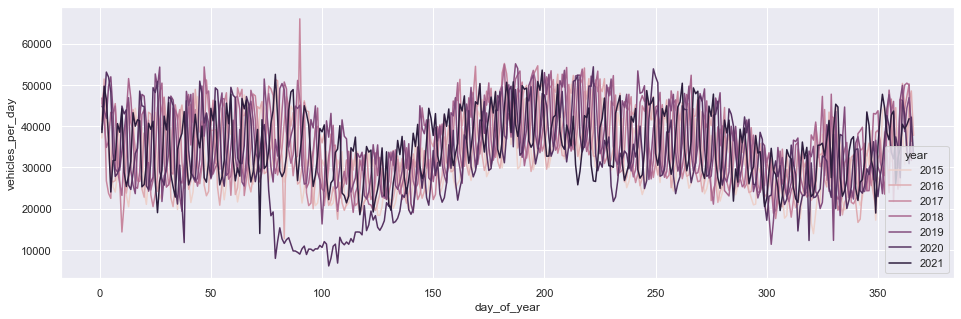

In [411]:
sns.lineplot(data=daily_totals, x="day_of_year", y="vehicles_per_day", hue="year")
sns.set(rc = {'figure.figsize':(16,5)})

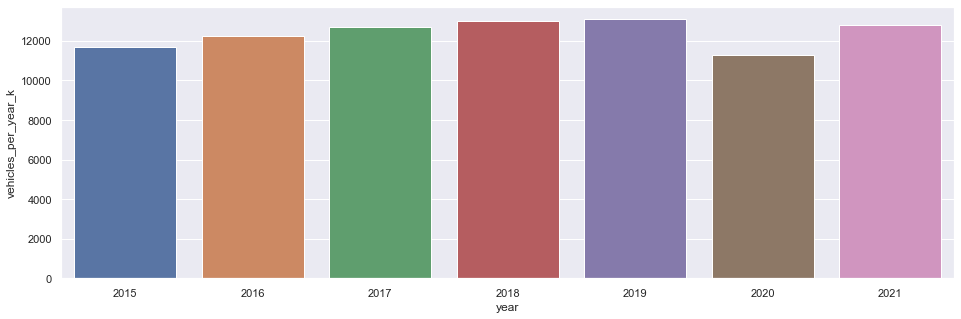

In [412]:
import seaborn as sns
import matplotlib.pyplot as plt

yearly_totals= daily_data_combined[[ 'vehicles_per_day','year' ]]
yearly_totals = yearly_totals.groupby('year').sum()/1000

yearly_totals=yearly_totals.rename(columns={"vehicles_per_day": "vehicles_per_year_k"})
yearly_totals.head()

#
# barplot annual totals
sns.barplot(x = yearly_totals.index,
            y = yearly_totals['vehicles_per_year_k'])
 
sns.set(rc = {'figure.figsize':(8,4)})

## Explore weather data

Take mean for each hour and compare against that hour relative based on precipitation.




In [413]:
hourly_data_combined.head(4)

count_date      count_datetime direction  month  week  hour  \
0 2015-01-01 2015-01-01 00:00:00         P      1     1     0   
1 2015-01-01 2015-01-01 00:00:00         S      1     1     0   
2 2015-01-01 2015-01-01 01:00:00         P      1     1     1   
3 2015-01-01 2015-01-01 01:00:00         S      1     1     1   

   vehicles_per_hour  temp_celsius  dew_pnt  rel_humidity  prcp_mm  measured  \
0               81.0         -10.0    -15.9          62.0      0.0      True   
1               97.0         -10.0    -15.9          62.0      0.0      True   
2               70.0         -10.0    -15.9          62.0      0.0      True   
3               91.0         -10.0    -15.9          62.0      0.0      True   

   temp_celsius_measured  day_of_year  day_of_week  weekend  holiday  
0                   True            1            3      0.0     True  
1                   True            1            3      0.0     True  
2                   True            1            3      0.0     True  
3                   True            1            3      0.0     True

In [414]:
# means for hour and direction
hour_values_mean = hourly_data_combined[["day_of_year","hour",  "direction",   "vehicles_per_hour", "prcp_mm" ]]
hour_values_mean=hour_values_mean.groupby(["day_of_year", "hour",  "direction"]).mean()

#rename columns
hour_values_mean=hour_values_mean.rename(columns={"vehicles_per_hour": "mean_vehicles_per_hour", "prcp_mm": "mean_prcp_mm"})
hour_values_mean.head(4)



mean_vehicles_per_hour  mean_prcp_mm
day_of_year hour direction                                      
1           0    P                       80.714286      0.042857
                 S                       87.142857      0.042857
            1    P                       71.428571      0.000000
                 S                       95.571429      0.000000

In [415]:

#join mean to hourly data, 
#hourly_data_combined_
hourly_data_combined_mean = pd.merge(
                   hourly_data_combined,
                   hour_values_mean,
                    how='left',
                    on=['day_of_year', 'hour', 'direction']

)


#new_df = pd.merge(A_df, B_df,  how='left', left_on=['A_c1','c2'], right_on = ['B_c1','c2'])

hourly_data_combined_mean.head()



hourly_data_combined_mean_pcp= hourly_data_combined_mean[["count_date", "count_datetime", "direction","prcp_mm", "vehicles_per_hour","mean_vehicles_per_hour"]]

hourly_data_combined_mean_pcp["veh_diff_from_mean_prcnt"]=(hourly_data_combined_mean_pcp["vehicles_per_hour"]- hourly_data_combined_mean_pcp["mean_vehicles_per_hour"])/hourly_data_combined_mean_pcp["mean_vehicles_per_hour"]




C:\Users\ckitc\AppData\Local\Temp\ipykernel_50680\2157022918.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



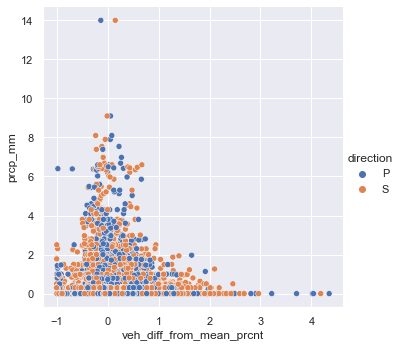

In [416]:
sns.relplot(
    data=hourly_data_combined_mean_pcp, x="veh_diff_from_mean_prcnt", y="prcp_mm", hue='direction'
)

The plot above compares the difference relative to the mean for each tunnel direction.  

Filter out Spring 2020, imputed rows, hours with 0 precipitation, plot as box or histogram

There may be a difference by direction.  Primary is east, west is secondary.
Values are lower than the mean for secondary count.  This could be that fewer people drive during storms or that the weather data west of the tunnel has preipitation on one side of the divide and not the other.

### Prepare Data for initial modelling
The hourly traffic data are imputed and merged with weather data. For our next steps we will create dummy variables for categorical variables, remove irrelevant features, standardize predictor variables, and divide the training data into test train sets.

In [417]:
hourly_data_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122688 entries, 0 to 122687
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   count_date             122688 non-null  datetime64[ns]
 1   count_datetime         122688 non-null  datetime64[ns]
 2   direction              122688 non-null  object        
 3   month                  122688 non-null  int64         
 4   week                   122688 non-null  UInt32        
 5   hour                   122688 non-null  int64         
 6   vehicles_per_hour      122688 non-null  float64       
 7   temp_celsius           122688 non-null  float64       
 8   dew_pnt                122688 non-null  float64       
 9   rel_humidity           122688 non-null  float64       
 10  prcp_mm                122688 non-null  float64       
 11  measured               122688 non-null  bool          
 12  temp_celsius_measured  122688 non-null  bool

In [418]:
# categorical variables to convert to dummy variables:
#direction

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (OneHotEncoder(), ['direction']),
    remainder='passthrough')

transformed = transformer.fit_transform(hourly_data_combined)
hourly_data_processed = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)


In [419]:
hourly_data_processed.head(2)

onehotencoder__x0_P onehotencoder__x0_S count_date count_datetime month  \
0                 1.0                 0.0 2015-01-01     2015-01-01     1   
1                 0.0                 1.0 2015-01-01     2015-01-01     1   

  week hour vehicles_per_hour temp_celsius dew_pnt rel_humidity prcp_mm  \
0    1    0              81.0        -10.0   -15.9         62.0     0.0   
1    1    0              97.0        -10.0   -15.9         62.0     0.0   

  measured temp_celsius_measured day_of_year day_of_week weekend holiday  
0     True                  True           1           3     0.0    True  
1     True                  True           1           3     0.0    True

In [420]:

#convert boolean to 0 or 1
# drop one hot encoder
#drop irrelevant columns
hourly_data_processed=hourly_data_processed.drop(['onehotencoder__x0_S', 'count_date',
                            'day_of_year','week', 'temp_celsius_measured',
                           'measured','weekend'
                           ], axis = 1)
hourly_data_processed.set_index('count_datetime', inplace=True)

hourly_data_processed["holiday"] = hourly_data_processed["holiday"].astype(int)

In [421]:
hourly_data_processed.head()

onehotencoder__x0_P month hour vehicles_per_hour  \
count_datetime                                                         
2015-01-01 00:00:00                 1.0     1    0              81.0   
2015-01-01 00:00:00                 0.0     1    0              97.0   
2015-01-01 01:00:00                 1.0     1    1              70.0   
2015-01-01 01:00:00                 0.0     1    1              91.0   
2015-01-01 02:00:00                 1.0     1    2              41.0   

                    temp_celsius dew_pnt rel_humidity prcp_mm day_of_week  \
count_datetime                                                              
2015-01-01 00:00:00        -10.0   -15.9         62.0     0.0           3   
2015-01-01 00:00:00        -10.0   -15.9         62.0     0.0           3   
2015-01-01 01:00:00        -10.0   -15.9         62.0     0.0           3   
2015-01-01 01:00:00        -10.0   -15.9         62.0     0.0           3   
2015-01-01 02:00:00        -10.0   -15.9         62.0     0.0           3   

                     holiday  
count_datetime                
2015-01-01 00:00:00        1  
2015-01-01 00:00:00        1  
2015-01-01 01:00:00        1  
2015-01-01 01:00:00        1  
2015-01-01 02:00:00        1

In [422]:
### Split into Test train and Standardize
# get features and respoinse variables
hourly_data_processed_P= hourly_data_processed.loc[
    (hourly_data_processed.onehotencoder__x0_P == 1)
] 
y = hourly_data_processed_P.vehicles_per_hour
X = hourly_data_processed_P.drop(['vehicles_per_hour'],axis=1)

# split into test train.
# time series should not be randomly sampled.  Holding out 1 year worth of rows
test_rows = 365*48 # 365 days, 24 hours, 2 directions. Hold out 1 year of data

X_train = X[:-test_rows]
X_test = X[-test_rows:]

y_train = y[:-test_rows]
y_test = y[-test_rows:]


In [423]:
# Standardize features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# transform data
X_train = scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [424]:
# get sample dimensions
print("Train")
print(X_train.shape)
print("Test")
print(X_test.shape)


Train
(43824, 9)
Test
(17520, 9)


In [425]:
# This portion concludes the pre-modelling data-munge.

## Modelling
Proposed Workflow:  
ARIMA model
Random Forest (random grid search)
Feature Engineering

In [426]:
hourly_data_processed = hourly_data_processed.rename(columns={'onehotencoder__x0_P': 'direction_P'})

hourly_data_processed.head(2)

direction_P month hour vehicles_per_hour temp_celsius dew_pnt  \
count_datetime                                                                 
2015-01-01             1.0     1    0              81.0        -10.0   -15.9   
2015-01-01             0.0     1    0              97.0        -10.0   -15.9   

               rel_humidity prcp_mm day_of_week  holiday  
count_datetime                                            
2015-01-01             62.0     0.0           3        1  
2015-01-01             62.0     0.0           3        1

### Time Series Analysis

In [427]:
# Filter down to one traffic direction.
# We may experiemnt with both
hourly_data_processed_P= hourly_data_processed.loc[
    (hourly_data_processed.direction_P == 1)
] 



In [428]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

# test if our time series is stationary
result = adfuller(hourly_data_processed_P.vehicles_per_hour.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print("p value <.05 allows us to reject the null hypothesis and conclude the time series is stationary")

ADF Statistic: -27.271664
p-value: 0.000000
p value <.05 allows us to reject the null hypothesis and conclude the time series is stationary


The P value is well below .05, we reject the null hypothesis and conclude that the time series is stationary. We don't need to calulate a difference model for our data.

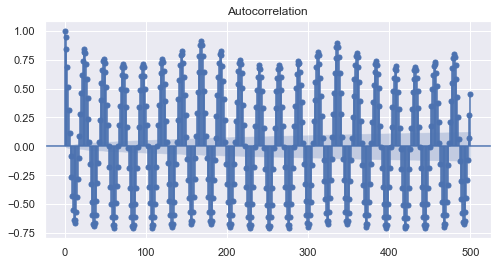

In [429]:
# create autocorrelation for traffic data

#filter to "primary" direction

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


plot_acf(hourly_data_processed_P.vehicles_per_hour, lags=500)
plt.show()

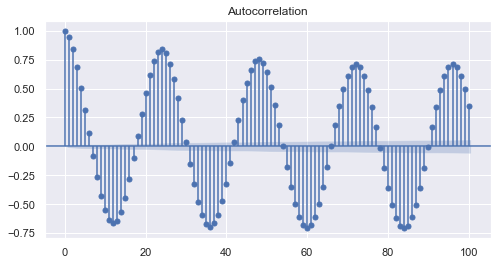

In [430]:
plot_acf(hourly_data_processed_P.vehicles_per_hour, lags=100)
plt.show()

The autocorrelation plot or correlogram summarizes the strength of the relationship from -1 to 1 between a value and a lag of k.  The 95% confidence interval is shown in the blue cone. The detrended data shows strong daily and weekly cyclicity. The high pearson coefficients indicate that past values are strongly correlated with future values.

Partial auto-correlation uses a similar approach to autocorrelation but calculates only the remaining correlation not explained by the previous lags. The 0 index value is the first row compared against itself which has an r2 of 1.  You can see that the previous two hours of data are predictive.

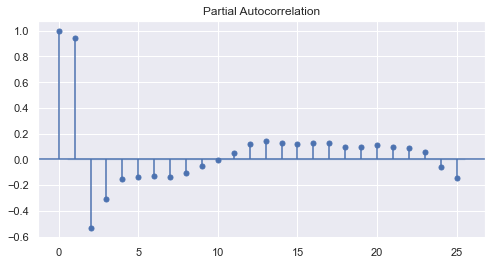

In [431]:
plot_pacf(hourly_data_processed_P.vehicles_per_hour, lags=25)
plt.show()

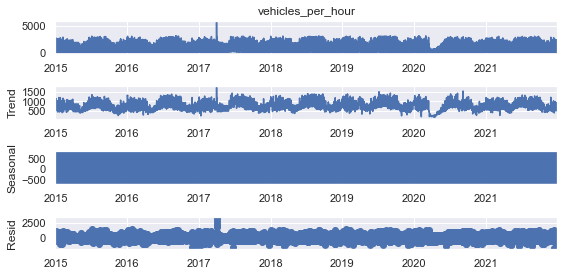

In [432]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(hourly_data_processed_P.vehicles_per_hour, model="additive")
decompose_data.plot()
plt.show()

The Partial autocorrelation plot indicates the last two hours have a high positive correlation with hourly traffic. The trend plot has a repeating "de-trended" pattern indicating no trend in y given t. The Seasonal plot has too much data to visualize any trends at the hourly resolution.

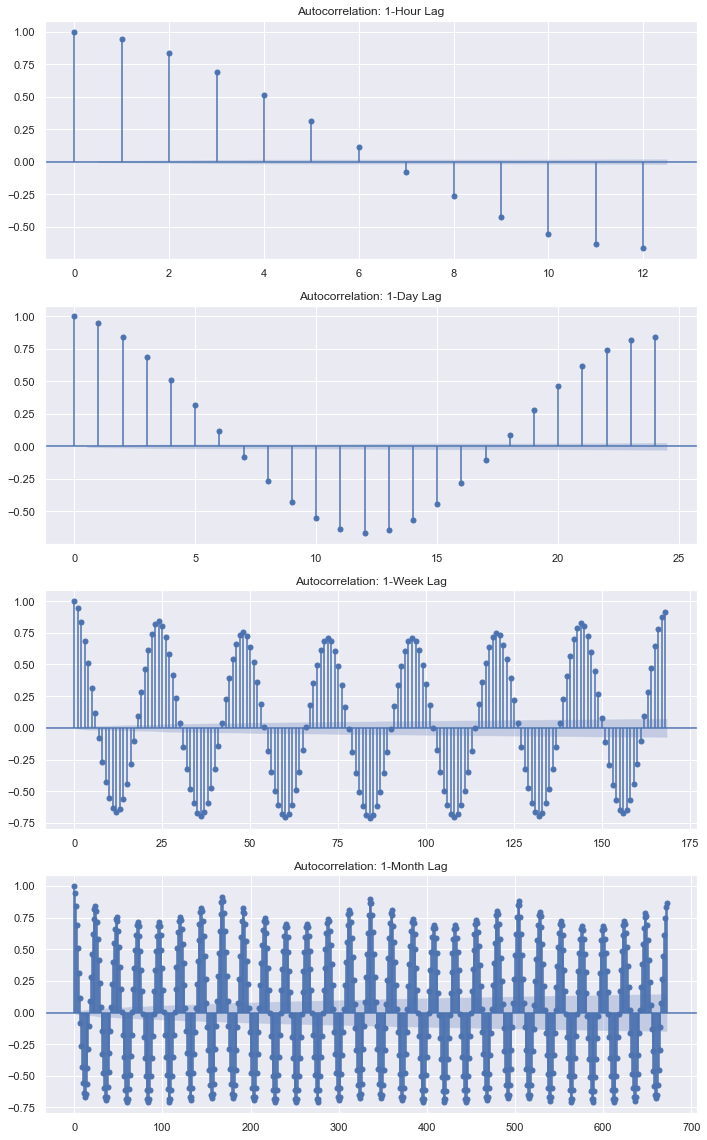

In [433]:
import statsmodels.tsa.api as smt

#create plots with different lag terms

def plot_multi_acf(data, lags, titles, ylim=None, partial=False):
    num_plots = len(lags)
    fig, ax = plt.subplots(len(lags), 1, figsize=(10, 4 * num_plots));
    if num_plots == 1:
        ax = [ax]
    acf_func = smt.graphics.plot_pacf if partial else smt.graphics.plot_acf
    for idx, (lag, title) in enumerate(zip(lags, titles)):
        fig = acf_func(data, lags=lag, ax=ax[idx], title=title);
        if ylim is not None:
            ax[idx].set_ylim(ylim);

    fig.tight_layout();

period_minutes = 60
samples_per_hour = int(60 / period_minutes)
samples_per_day = int(24 * samples_per_hour)
samples_per_week = int(7 * samples_per_day)
samples_per_month=int(4*samples_per_week)

lags = [12 * samples_per_hour, samples_per_day, samples_per_week, samples_per_month]
titles= ['Autocorrelation: 1-Hour Lag',
         'Autocorrelation: 1-Day Lag',
         'Autocorrelation: 1-Week Lag',
         'Autocorrelation: 1-Month Lag'
        ]

plot_multi_acf(hourly_data_processed_P.vehicles_per_hour, lags, titles)

# after https://www.ethanrosenthal.com/2018/03/22/time-series-for-scikit-learn-people-part2/

The hourly traffic data exbitit cyclicity at the monthly, weekly, and hourly data.  The lagged values are highly correlated with a given row and stay high. Tools such as ARIMA, SARIMA, and Prophet should perform well.

## Model Assessment Tools

In [434]:
#Define function to plot residuals of a model and a density distribution

# Plot residual errors
def resid_plots(model_of_interest) :
    residuals = pd.DataFrame(model_of_interest.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

In [435]:
# Define function to create accuracy metrics
def forecast_accuracy(prediction, test):
    mape = np.mean(np.abs(prediction - test)/np.abs(test))  # MAPE
    me = np.mean(prediction - test)             # ME
    mae = np.mean(np.abs(prediction - test))    # MAE
    mpe = np.mean((prediction - test)/test)   # MPE
    rmse = np.mean((prediction - test)**2)**.5  # RMSE
    corr = np.corrcoef(prediction, test)[0,1]   # corr
    mins = np.amin(np.hstack([prediction[:,None], 
                              test[:,None]]), axis=1)
    maxs = np.amax(np.hstack([prediction[:,None], 
                              test[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,  
            'corr':corr, 'minmax':minmax})

# modified from https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

### Arima

Arima data needs to be further processed. An ARIMA model can't use additional independent variables such as temperature or precipitation.
The Model only uses time and the "trends" and values o

## weekly Arima Model for testing

The resolution of the hourly data was reduced to a weekly summary for one driving direction (Primary/West). THis was done to simplify the models and reduce the data size for experimenting with our various model type.  We will still apply these models on the hourly or daily data later on in the workflow.

We need to specify p,d, and q in that order as arguments for the model.
p is the lag of the autoreregression, d is the degree of differencing, and q is the lag for the moving average.
These parameters are derived for the autocorrelation and partial correlation plots.
To derive the order of differencing "d" we use the Augmented Dickey-Fuller to establish if the data are "stationary" or if they need additional differencing.  The test has a very low p-value indicating that the series is "stationary", the proposed value for d is "0"



In [436]:
import pandas as pd

#resample data to weekly for direction "P" (primary/West)
weekly_data_arima_P = hourly_data_processed_P[['vehicles_per_hour']].resample('W').sum()
weekly_data_arima_P.rename(columns = {'vehicles_per_hour':'vehicles_per_week'}, inplace = True)


#partial weeks due to data pull skew low at the beginning and end of the data. 
#Exclude first and last row of data
weekly_data_arima_P = weekly_data_arima_P.iloc[1:-1 , :]

weekly_data_arima_P.head(3)

vehicles_per_week
count_datetime                   
2015-01-11               114456.0
2015-01-18               105454.0
2015-01-25               123237.0

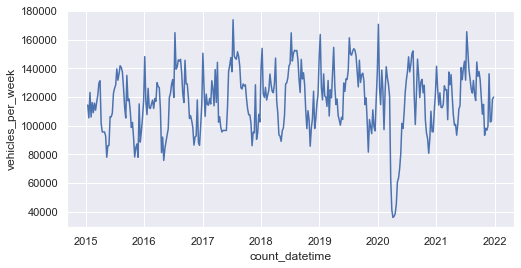

In [437]:
sns.lineplot(data=weekly_data_arima_P, x=weekly_data_arima_P.index, y="vehicles_per_week")
sns.set(rc = {'figure.figsize':(16,5)})

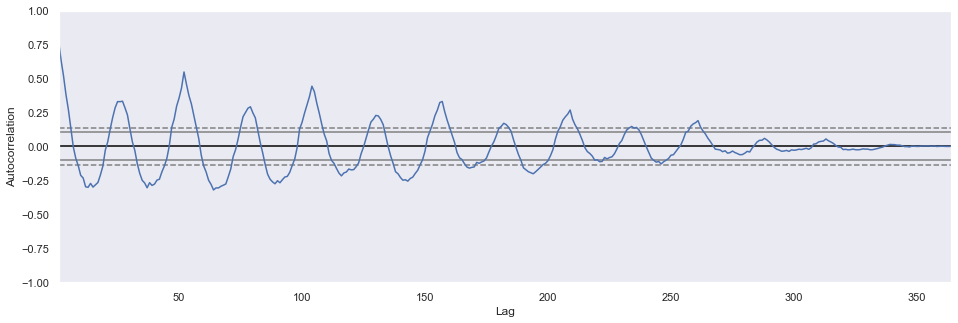

In [438]:
#Chack autocorrelation
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(weekly_data_arima_P['vehicles_per_week'])
plt.show()

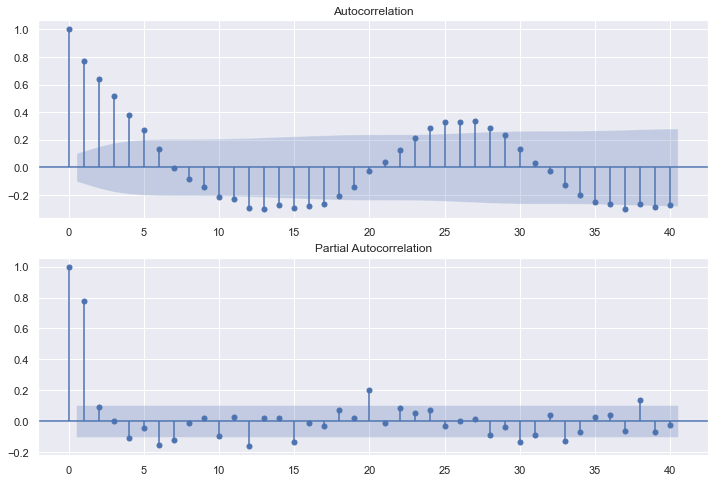

In [439]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(weekly_data_arima_P['vehicles_per_week'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(weekly_data_arima_P['vehicles_per_week'].dropna(),lags=40,ax=ax2)

On the autocorrelation plot the weekly totals indicate that the last 4 weeks of trafffic data are predictive of a given value.  The Partial autocorrelation indicates the unique information in each lag.  In this context only the last two weekly values are predictive of a given row.

In [440]:
# Again testing if data is stationary
stationary_test=adfuller(weekly_data_arima_P['vehicles_per_week'].dropna())
print('p-value: %f' % stationary_test[1])

#small p values, data are stationary (d=0)

p-value: 0.000000


In [441]:
# Split data into test train for the weekly ARIMA and SARIMA models.
from statsmodels.tsa.stattools import acf

#X = weekly_data_arima_P.values.astype('float64')
X=weekly_data_arima_P

## Create Training and Test
size = int(len(X) * .85)


train_weekly= X.vehicles_per_week[:size]
test_weekly = X.vehicles_per_week[size:len(X)]

#
#train_weekly = df.value[:85]
#test_weekly = df.value[85:]

In [442]:
#weekly_fit.forecast(size, alpha=0.05)

In [443]:
# For non-seasonal data
# Manual Arima Specification based off of the auto-correlation and partial auto-correlation plots
#p=2, d=0, q=2 

from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train_weekly,order=(2,0,2))
weekly_fit=model.fit()
weekly_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      vehicles_per_week   No. Observations:                  309
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -3386.397
Date:                Thu, 23 Jun 2022   AIC                           6784.794
Time:                        21:05:20   BIC                           6807.194
Sample:                    01-11-2015   HQIC                          6793.749
                         - 12-06-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.175e+05   2270.726     51.733      0.000    1.13e+05    1.22e+05
ar.L1          1.7953      0.065     27.601      0.000       1.668       1.923
ar.L2         -0.8412      0.057    -14.647      0.000      -0.954      -0.729
ma.L1         -1.1415      0.077    -14.764      0.000      -1.293      -0.990
ma.L2          0.2638      0.064      4.131      0.000       0.139       0.389
sigma2      2.032e+08      0.006   3.68e+10      0.000    2.03e+08    2.03e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                14.99
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  6e+26. Standard errors may be unstable.
"""

55
55


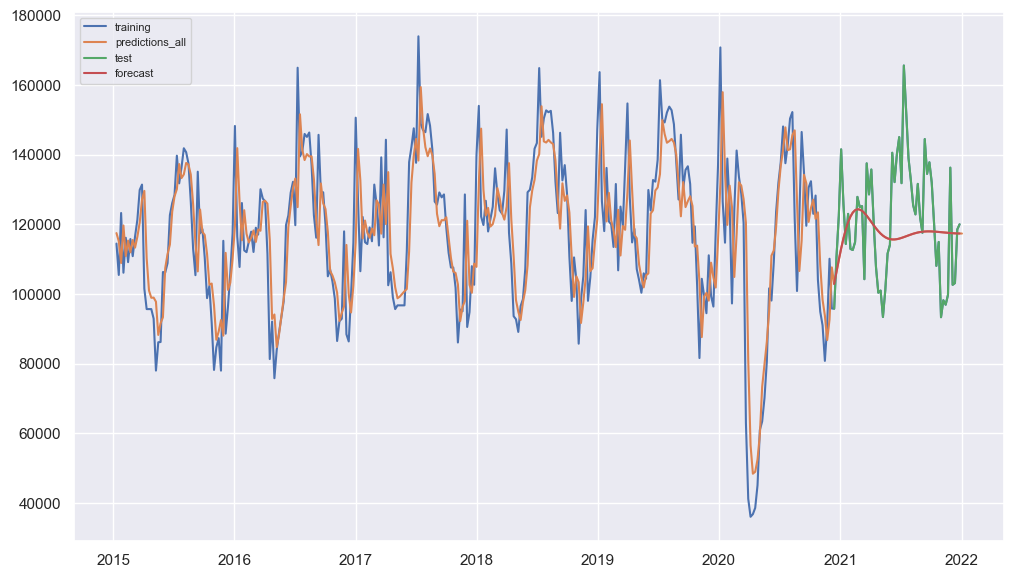

In [444]:

train_length=size
total_length=len(X)
forecast_length=total_length-train_length

print(len(test_weekly))
print(forecast_length)

#forecast out to compare with test data
fc=weekly_fit.forecast(forecast_length)


weekly_predict=pd.Series(weekly_fit.predict(start=0,end=total_length, data=X))
#weekly_predict

# Make as pandas series
fc_series = pd.Series(fc, index=test_weekly.index)
plt.figure(figsize=(12,7), dpi=100)
plt.plot(X, label='training')
plt.plot(weekly_predict, label='predictions_all')
plt.plot(test_weekly, label='test')
plt.plot(fc_series, label='forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

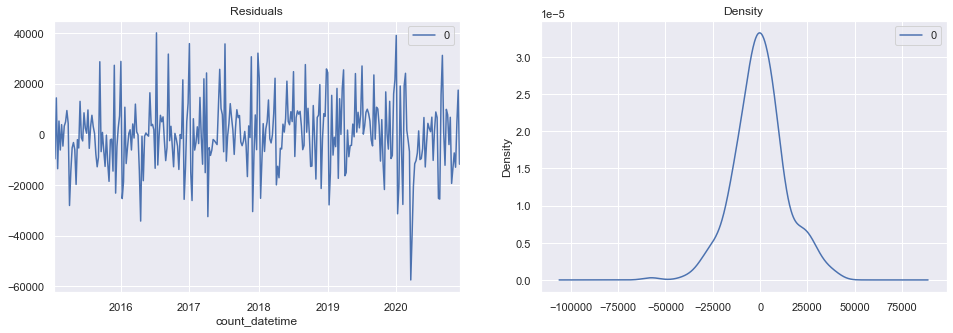

In [445]:
resid_plots(weekly_fit)

The summary above for our first ARIMA (autoregressive integreted moving average) was specified using a pdq of 2,0,2 respectively.  The first and last vlaue are using the previous 2 rows to predict a given row.  the d=0, indicates that there's no trend in our data and that we don't need to difference the data.  The coefficients seem reasonable and the p values are all well below the .05 threshold indicating they may be significant. 

Plotting the predictions tells a different story.  The predictions in the training set fit the data very well, the predictions to the test set leave much to be desired.  The model does predict relatively higher values and lower values that correpasond with highs and lows in the test set but the magnitude and fidelity of the predictions are way off.

The data are stationay, but we may need to add seasonality to the trend.  We can do this with SARIMA.  First we will attempt an auto-Arima and see if we can improve the hyperparameters.


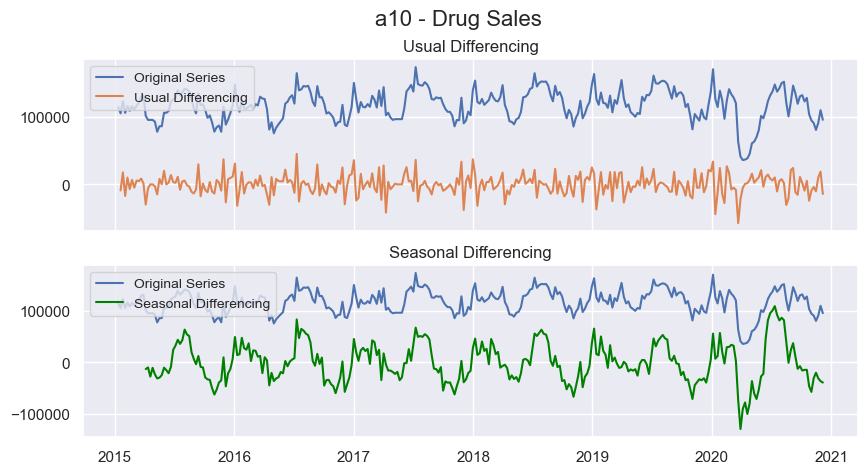

In [446]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(train_weekly[:], label='Original Series')
axes[0].plot(train_weekly[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# Seasonal Differencing
axes[1].plot(train_weekly[:], label='Original Series')
axes[1].plot(train_weekly[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

Looking at the two difference plots, the normal differencing does have the desired effect.  Despite the AD Fuller test the data may not be stationary. We will adjust the values for d and D in the auto-ARIMA and auto-SARIMA.  The seasonal differencing does not show the correct pattern and may require a second order differencing.

In [447]:
#Auto SARIMAS
#from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
auto_weekly_arima = pm.auto_arima(train_weekly, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=0,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      max_P=5,
                      max_D=5,
                      max_Q=5,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      n_fits = 50           )

print(auto_weekly_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=7066.769, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7088.374, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6788.178, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6943.447, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8105.053, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6792.884, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6788.669, Time=1.24 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6787.889, Time=0.08 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6788.000, Time=0.24 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6789.883, Time=0.68 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=6787.427, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=6792.790, Time=0.05 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=6789.253, Time=0.46 sec
 ARIMA(2,0,0)(0,0,2)[12]

364
55
55


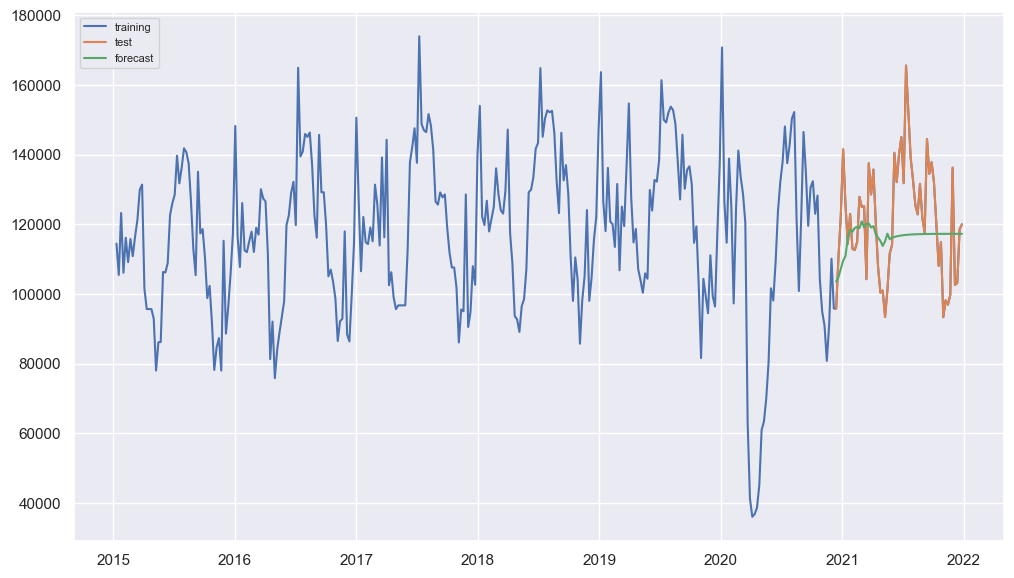

In [448]:
# Plot Auto  ARIMA
#auto_weekly_sarima
train_length=size
total_length=len(X)
forecast_length=total_length-train_length
fc=auto_weekly_arima.predict(n_periods=forecast_length)
# Make as pandas series
fc_series = pd.Series(fc, index=test_weekly.index)

print(total_length)
print(len(test_weekly))
print(forecast_length)


weekly_predict=pd.Series(auto_weekly_arima.predict(start=0,end=total_length, data=X))
#weekly_predict

# Forecast
#fc = auto_weekly_sarima.forecast(80)  # 95% conf


plt.figure(figsize=(12,7), dpi=100)
plt.plot(X, label='training')
#plt.plot(weekly_predict, label='predictions_all')
plt.plot(test_weekly, label='test')
plt.plot(fc_series, label='forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [449]:
#Auto SARIMA
# Seasonal - fit stepwise auto-ARIMA
auto_weekly_sarima = pm.auto_arima(train_weekly, start_p=1, start_q=1,
                         test='adf',
                         max_p=20, max_q=20, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

auto_weekly_sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=6787.457, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7088.374, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6788.178, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6943.447, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8105.053, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=6792.959, Time=0.03 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=6788.400, Time=0.52 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=6787.239, Time=0.30 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=6789.117, Time=0.99 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=6941.593, Time=0.24 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6788.000, Time=0.24 sec
 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=6789.178, Time=0.44 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=6789.239, Time=0.33 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=7060.682, Time=0.16 sec
 ARIMA(0,0,2)(0,0,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  309
Model:             SARIMAX(1, 0, 1)x(0, 0, [1, 2], 12)   Log Likelihood               -3387.619
Date:                                 Thu, 23 Jun 2022   AIC                           6787.239
Time:                                         21:05:44   BIC                           6809.639
Sample:                                              0   HQIC                          6796.195
                                                 - 309                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.238e+04   5835.326      3.836      0.000    1.09e+04    3.38e+04
ar.L1          0.8091      0.049     16.382      0.000       0.712       0.906
ma.L1         -0.1085      0.070     -1.559      0.119      -0.245       0.028
ma.S.L12      -0.1511      0.053     -2.828      0.005      -0.256      -0.046
ma.S.L24       0.0955      0.065      1.466      0.143      -0.032       0.223
sigma2      2.014e+08      0.155    1.3e+09      0.000    2.01e+08    2.01e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.83
Prob(Q):                              1.00   Prob(JB):                         0.05
Heteroskedasticity (H):               1.65   Skew:                             0.04
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.63e+24. Standard errors may be unstable.
"""

364
55
55


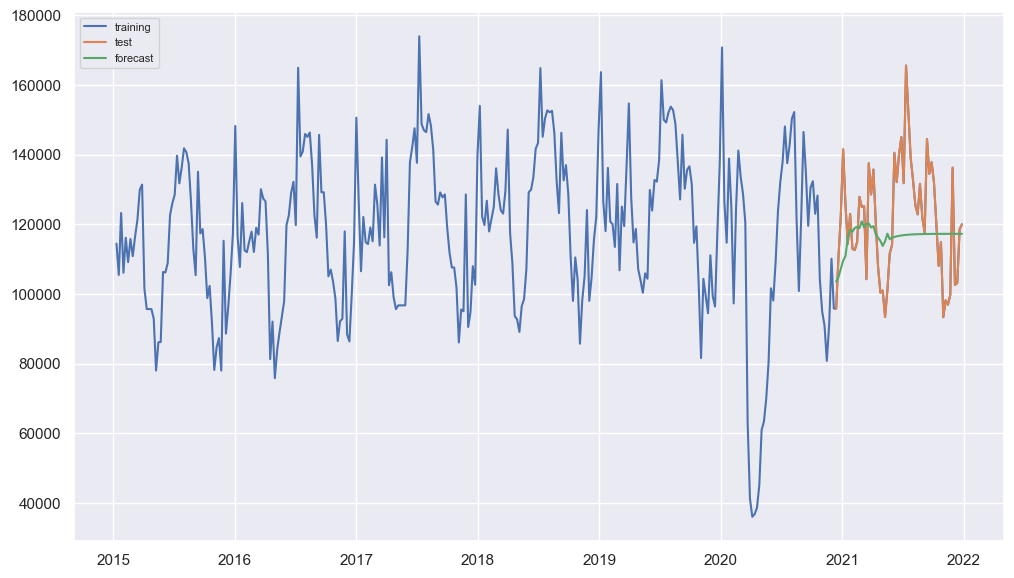

In [450]:
# Plot AutoSarima
#auto_weekly_sarima
train_length=size
total_length=len(X)
forecast_length=total_length-train_length
fc=auto_weekly_sarima.predict(n_periods=forecast_length)

print(total_length)
print(len(test_weekly))
print(forecast_length)


#weekly_predict

# Forecast
#fc = auto_weekly_sarima.forecast(80)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_weekly.index)
plt.figure(figsize=(12,7), dpi=100)
plt.plot(X, label='training')
plt.plot(test_weekly, label='test')
plt.plot(fc_series, label='forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The AutoArima and AutoSarima determined the optimum models with the lowest AIC values were very similar to manually-specified ARIMA model.  Overall the fits improved slightly with a bit more character in the repdictions but the magnitude of the predictions don't allign with the test data.  

# Facebook Prophet

Despite a rigorous attempt to fit the ARIMA and SARIMA models both manually and automatically the "best" models were relatively poor. It's 
Next we will experiment using the Prophet time series forecasting package developed by Facebook.

## Weekly Prophet Model

In [451]:
#weekly prophet model
# check version load libraries

from prophet import Prophet
from prophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()


#prophet.__version__

# derived from https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet/notebook

In [452]:
train_weekly.head()

count_datetime
2015-01-11    114456.0
2015-01-18    105454.0
2015-01-25    123237.0
2015-02-01    106095.0
2015-02-08    116129.0
Freq: W-SUN, Name: vehicles_per_week, dtype: float64

In [453]:
#Prophect API requires the columns be formatted with the proper column names (ds and y)
train_weekly_fb=pd.DataFrame(train_weekly)
train_weekly_fb['count_date'] = train_weekly_fb.index

train_weekly_fb = train_weekly_fb.rename(columns={'count_date': 'ds',
                        'vehicles_per_week': 'y'})
train_weekly_fb=train_weekly_fb[['ds','y'  ]]
#
train_weekly_fb.head()


ds         y
count_datetime                     
2015-01-11     2015-01-11  114456.0
2015-01-18     2015-01-18  105454.0
2015-01-25     2015-01-25  123237.0
2015-02-01     2015-02-01  106095.0
2015-02-08     2015-02-08  116129.0

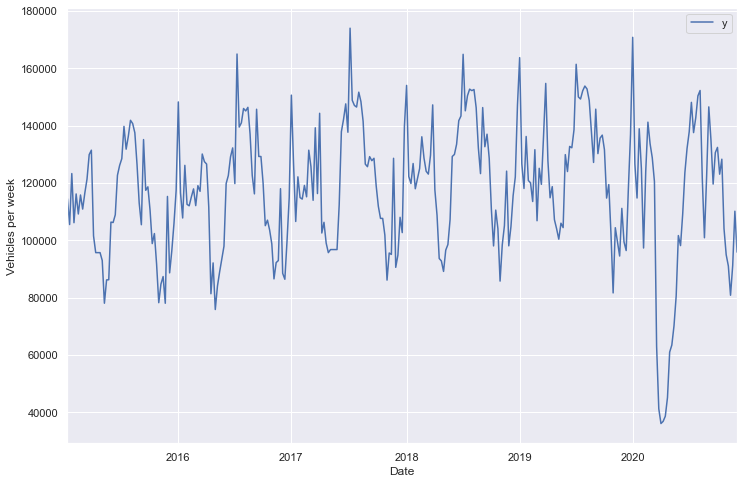

In [454]:
ax = train_weekly_fb.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Vehicles per week')
ax.set_xlabel('Date')

plt.show()

In [455]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
prophet_weekly = Prophet(interval_width=0.95)
prophet_weekly.fit(train_weekly_fb)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [456]:
prophet_forecast = prophet_weekly.make_future_dataframe(periods=forecast_length, freq='W')
prophet_forecast = prophet_weekly.predict(prophet_forecast)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()


ds          yhat     yhat_lower     yhat_upper
0 2015-01-11  128593.65233  101902.624150  156028.928530
1 2015-01-18  116275.62212   89986.916803  140149.650539
2 2015-01-25  107031.87714   82158.808165  131734.323535
3 2015-02-01  107325.60815   83262.628846  133013.769591
4 2015-02-08  113055.05880   89230.741516  138641.053871

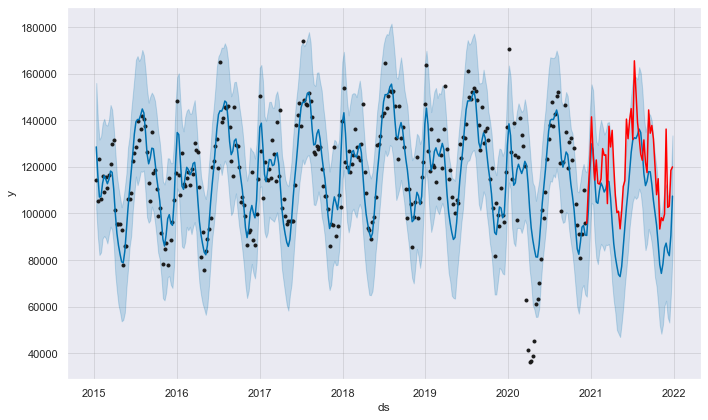

In [457]:
prophet_weekly.plot(prophet_forecast, uncertainty=True)
plt.plot(test_weekly, label='test',color='red')

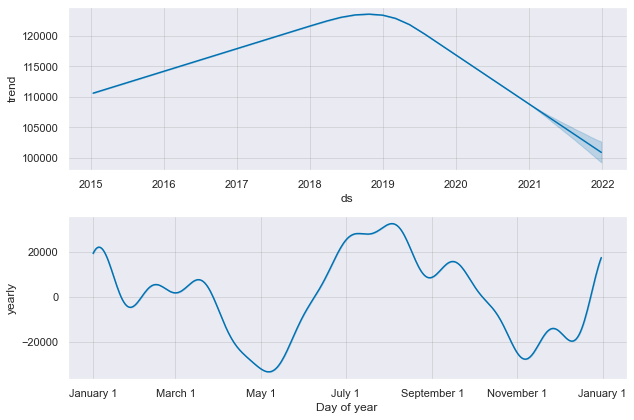

In [458]:
prophet_weekly.plot_components(prophet_forecast);


In [459]:
#rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=1), 4)
#fit = rfe.fit(finaldf_train_x, finaldf_train_y)
#y_pred = fit.predict(finaldf_test_x)

The prophet model perforrms well right out of the box.
## Hourly Prophet Model

In [460]:
# we will try an hourly model but we will include the DIRECTION as an additional regressor in the model.

In [461]:
hourly_data_processed.head()

direction_P month hour vehicles_per_hour temp_celsius  \
count_datetime                                                              
2015-01-01 00:00:00         1.0     1    0              81.0        -10.0   
2015-01-01 00:00:00         0.0     1    0              97.0        -10.0   
2015-01-01 01:00:00         1.0     1    1              70.0        -10.0   
2015-01-01 01:00:00         0.0     1    1              91.0        -10.0   
2015-01-01 02:00:00         1.0     1    2              41.0        -10.0   

                    dew_pnt rel_humidity prcp_mm day_of_week  holiday  
count_datetime                                                         
2015-01-01 00:00:00   -15.9         62.0     0.0           3        1  
2015-01-01 00:00:00   -15.9         62.0     0.0           3        1  
2015-01-01 01:00:00   -15.9         62.0     0.0           3        1  
2015-01-01 01:00:00   -15.9         62.0     0.0           3        1  
2015-01-01 02:00:00   -15.9         62.0     0.0           3        1

In [462]:
#X = weekly_data_arima_P.values.astype('float64')

X=hourly_data_processed

X= X.loc[
    (X.direction_P == 1)
] 
X.sort_index(ascending=True)
## Create Training and Test
size = int(len(X) * .8)
train_length=size
total_length=len(X)
forecast_length=total_length-train_length

train_hourly= X[:size]
test_hourly = X[size:len(X)]

print(forecast_length)

12269


In [463]:
#Prophect API requires the columns be formatted with the proper column names (ds and y)
train_hourly_fb=pd.DataFrame(train_hourly)
train_hourly_fb['count_datetime'] = train_hourly_fb.index
#
train_hourly_fb.head()
train_hourly_fb = train_hourly_fb.rename(columns={'count_datetime': 'ds',
                        'vehicles_per_hour': 'y', 'direction_P':'add1'})

train_hourly_fb=train_hourly_fb[['ds','y'  ]]
##
train_hourly_fb.head()

ds     y
count_datetime                               
2015-01-01 00:00:00 2015-01-01 00:00:00  81.0
2015-01-01 01:00:00 2015-01-01 01:00:00  70.0
2015-01-01 02:00:00 2015-01-01 02:00:00  41.0
2015-01-01 03:00:00 2015-01-01 03:00:00  55.0
2015-01-01 04:00:00 2015-01-01 04:00:00  77.0

In [464]:

#Train hourly Model (may take a while)
# set the uncertainty interval to 95% (the Prophet default is 80%)
prophet_hourly = Prophet(interval_width=0.95)
#prophet_hourly.add_regressor('add1')
prophet_hourly.fit(train_hourly_fb)



In [465]:
#Predictions
prophet_hourly_forecast = prophet_hourly.make_future_dataframe(periods=forecast_length, freq='H')
#prophet_hourly_forecast[["add1"]]=1
#prophet_hourly_forecast
prophet_hourly_forecast = prophet_hourly.predict(prophet_hourly_forecast)

prophet_hourly_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()


ds       yhat  yhat_lower  yhat_upper
0 2015-01-01 00:00:00  19.767961 -468.799971  534.794403
1 2015-01-01 01:00:00 -10.710223 -502.734377  475.819657
2 2015-01-01 02:00:00 -11.155094 -502.582023  472.591806
3 2015-01-01 03:00:00   5.896572 -508.054153  485.516294
4 2015-01-01 04:00:00  38.772423 -416.303036  566.523056

(0.0, 4000.0)

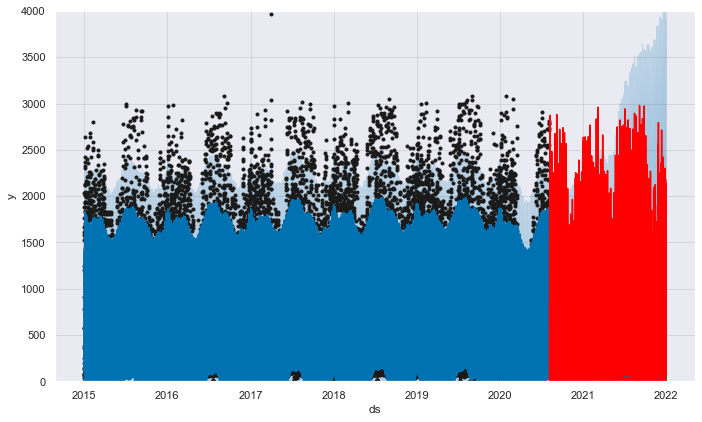

In [466]:
prophet_hourly.plot(prophet_hourly_forecast, uncertainty=True)
plt.plot(test_hourly, label='test',color='red')
plt.ylim((0, 4000))  

It is difficult to resolve how well the model is perofrming on the hourly data.  We will zoom in on the last few training points and the first few test points

(0.0, 3000.0)

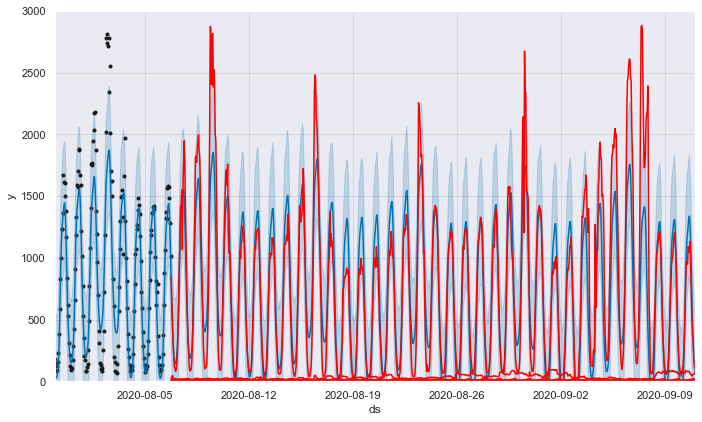

In [467]:
import matplotlib.pyplot as plt
prophet_hourly.plot(prophet_hourly_forecast, uncertainty=True)
plt.plot(test_hourly, label='test',color='red')
plt.xlim([pd.to_datetime('2020-07-29 23:50:00'), pd.to_datetime('2020-09-10 23:50:00')])
plt.ylim((0, 3000))  


The hourly prophet model performs semi-satisfactorily "out of the box".  The model is failing to capture the peak traffic patterns observed on Weekends. The weekend troughs are also pdicted much lower than expected.  in most cases the predicitons fall within the 95% confidence interval with the exception of weekends and holidays. We won't spend more time here but additional tuning would likely help the model.  We could also explore "chaining" two models where we use the westbound traffic to predict eastbound traffic.  Overall, the model is responding to the fluctuations in the data but improvements are likely possible and necessary.
Holidays need to be added seperately to Prophet but that would likely greatly enhance the performacne of the model.
The model is occassionally predicting negative values which is impossible in this use case. We could try a log transform or scaling to minimize the number of negative values.


In [468]:
prophet_hourly_predictions=prophet_hourly_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')
prophet_hourly_predictions.head()


yhat  yhat_lower  yhat_upper
ds                                                    
2015-01-01 00:00:00  19.767961 -468.799971  534.794403
2015-01-01 01:00:00 -10.710223 -502.734377  475.819657
2015-01-01 02:00:00 -11.155094 -502.582023  472.591806
2015-01-01 03:00:00   5.896572 -508.054153  485.516294
2015-01-01 04:00:00  38.772423 -416.303036  566.523056

In [469]:
#test_hourly.head()


In [470]:
#combine predictions with test values
test_pred=pd.merge(test_hourly, prophet_hourly_predictions, left_index=True, right_index=True)
test_pred.head()



direction_P month hour vehicles_per_hour temp_celsius  \
2020-08-06 19:00:00         1.0     8   19             849.0         16.0   
2020-08-06 20:00:00         1.0     8   20             638.0         18.0   
2020-08-06 21:00:00         1.0     8   21             521.0         12.0   
2020-08-06 22:00:00         1.0     8   22             323.0         18.0   
2020-08-06 23:00:00         1.0     8   23             205.0         19.0   

                    dew_pnt rel_humidity prcp_mm day_of_week  holiday  \
2020-08-06 19:00:00    -1.1         31.0     0.0           3        0   
2020-08-06 20:00:00    -0.8         28.0     0.0           3        0   
2020-08-06 21:00:00     1.0         47.0     0.0           3        0   
2020-08-06 22:00:00    -0.8         28.0     0.0           3        0   
2020-08-06 23:00:00    -3.8         21.0     0.0           3        0   

                           yhat  yhat_lower   yhat_upper  
2020-08-06 19:00:00  771.309036  290.678475  1254.759351  
2020-08-06 20:00:00  578.268081  112.343846  1078.371194  
2020-08-06 21:00:00  428.449468  -52.712440   928.399109  
2020-08-06 22:00:00  312.621952 -165.334902   795.902110  
2020-08-06 23:00:00  223.574990 -281.180798   731.552997

In [471]:
# Define function to create accuracy metrics
pred=test_pred[["yhat"]]
ac=test_pred[["vehicles_per_hour"]]


mse= np.mean(np.square(test_pred["yhat"] - test_pred["vehicles_per_hour"]))
rmse=np.sqrt(mse)
#corr = np.corrcoef(test_pred["yhat"], test_pred["vehicles_per_hour"])[0,1]

print(  'mse  ' + str(round(mse))) 
print( 'rmse  ' + str(round(rmse)))


mse  103908
rmse  322


# Documentation








# Hourly Models

In [472]:
## hourly arima model
#hourly_data_arima_P = hourly_data_processed_P[['vehicles_per_hour']]
#hourly_data_arima_P['vehicles_per_hour'] = pd.to_numeric(hourly_data_arima_P['vehicles_per_hour'])
#hourly_data_arima_P.head(3)
#

In [473]:
##Evaluate an ARIMA model for Westbound Traffic (primary)
#
#from matplotlib import pyplot
#from statsmodels.tsa.arima.model import ARIMA
#from sklearn.metrics import mean_squared_error
#from math import sqrt
#
#
#X = hourly_data_arima_P.values.astype('float64')
#size = int(len(X) * .8)
#train, test = X[0:size], X[size:len(X)]
#
#arima_model_p=ARIMA(train, order=(1,0,10))
#arima_model_p=arima_model_p.fit()
#print(arima_model_p.summary())
##code excerpt from 
##https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [474]:
#import statsmodels.api as sm
#import matplotlib.pyplot as plt
#
##hourly_data_arima_P['prediction']=arima_model_p.predict(dynamic=True)
#
#hourly_data_arima_P_out=hourly_data_arima_P
#hourly_data_arima_P_out.loc[:,'prediction'] = arima_model_p.predict(dynamic=True)
#hourly_data_arima_P_out[['vehicles_per_hour','prediction']].plot(figsize=(12,8))

In [475]:
#print(hourly_data_arima_P.min())
#print(hourly_data_arima_P.max())

In [476]:
#hourly_data_arima_P.dtypes

In [311]:
#hourly_data_arima_P.dtypes

In [312]:
#tidbits
#from statsmodels.graphics.tsaplots import plot_predict
#
#plot_predict(weekly_fit, dynamic=False)
#weekly_data_arima_P.plot()
##weekly_fit.plot_predict(dynamic=False)
#plt.show()

